# Project: Air Quality Prediction in Lombardy Region
---
**Name:** Kant Charoensedtasin (Gun)

# Background and Problem Statement
---
**Background**

The Lombardy region is one of the most polluted region in Europe. There is a large evidence that the agricultural section has a significant impact on air quality. The Lombardy region has several agicultural section then there are large amount of pollutants emitted to the air. The data scientists in the Lombardy region were assigned to build the model to predicting the pollutants quantity in the air. The model which predicted the pollutants in the air might help to decide the next actionable plan for balancing between agricultural products and air quality.

**Problem Statement**
1. The data scientists were assign to build the time series model architecture for predicting each pollutants of each station in the Lombardy region.
2. Identify the bad air quality days from the model and comparing to the actual value.
3. Recommendation for improving the time series model

**Note** - Because the time series data has large fluctuation in the data, the model might be not good to capture all of the fluctuation in the data. So, the model in this project might be not that accuracy compare to normal regression problem.

# Data Preparation and Exploration Data Analysis
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import initializers

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


[Agrimonia_Dataset](https://zenodo.org/record/6620530#.Y1Fkf3bP1PY)
- [Air quality index](https://airindex.eea.europa.eu/Map/AQI/Viewer/#)
- [Air quality index2](https://www.euronews.com/weather/copernicus-air-quality-index)

## Data cleaning

In [2]:
df = pd.read_csv("./data/Agrimonia_Dataset.csv",low_memory=False)

In [3]:
df.head()

IDStations   Latitude  Longitude        Time  Altitude    AQ_pm10  \
0       1264  46.167852    9.87921  2016-01-01       290  6.200e+01   
1       1264  46.167852    9.87921  2016-01-02       290  7.300e+01   
2       1264  46.167852    9.87921  2016-01-03       290  4.400e+01   
3       1264  46.167852    9.87921  2016-01-04       290  3.100e+01   
4       1264  46.167852    9.87921  2016-01-05       290  2.700e+01   

     AQ_pm25       AQ_co     AQ_nh3     AQ_nox  ... EM_nh3_sum EM_nox_traffic  \
0  5.300e+01         NaN        NaN  8.263e+01  ...  6.166e-01      8.359e-01   
1  6.300e+01         NaN        NaN  1.017e+02  ...  6.298e-01      8.372e-01   
2  3.900e+01         NaN        NaN  6.626e+01  ...  6.424e-01      8.384e-01   
3  2.900e+01         NaN        NaN  6.331e+01  ...  6.545e-01      8.396e-01   
4  2.600e+01         NaN        NaN  7.553e+01  ...  6.660e-01      8.409e-01   

   EM_nox_sum  EM_so2_sum    LI_pigs  LI_bovine  LA_hvi  LA_lvi  LA_land_use  \
0   1.720e+00   3.906e-01  3.832e-01  5.892e+00   3.998   1.234        112.0   
1   1.720e+00   3.911e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
2   1.720e+00   3.916e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
3   1.720e+00   3.923e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
4   1.720e+00   3.931e-01  3.832e-01  5.892e+00   3.997   1.233        112.0   

   LA_soil_use  
0         17.0  
1         17.0  
2         17.0  
3         17.0  
4         17.0  

[5 rows x 41 columns]

In [4]:
# Check shape of the data set
df.shape

(309072, 41)

In [5]:
# Check type of the data set
df.dtypes

IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_pm25                         object
AQ_co                           object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
AQ_so2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipication_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_10

In [6]:
# Check missing value in the data set
df.isnull().sum()[df.isnull().sum() != 0]

LA_land_use      6576
LA_soil_use    160738
dtype: int64

In [7]:
# Select object columns
object_col = df.select_dtypes(include='object').columns
object_col

Index(['IDStations', 'Time', 'AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox',
       'AQ_no2', 'AQ_so2', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine'],
      dtype='object')

In [8]:
# `NaN` in the air quality columns is imputed the value 
# which is noise of the data.
aq_col = ['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3',
          'AQ_nox', 'AQ_no2', 'AQ_so2']
for col in list(aq_col):
    print(f"Missing value 'NaN' in column {col}: {df[col].str.contains('NaN').sum()}")

Missing value 'NaN' in column AQ_pm10: 89634
Missing value 'NaN' in column AQ_pm25: 208379
Missing value 'NaN' in column AQ_co: 197180
Missing value 'NaN' in column AQ_nh3: 292617
Missing value 'NaN' in column AQ_nox: 107843
Missing value 'NaN' in column AQ_no2: 49132
Missing value 'NaN' in column AQ_so2: 227026


In [9]:
# Remove space of `NaN` value in dataframe
df = df.replace('\s+','',regex=True)

In [10]:
# Impute missing all `NaN` value with 0
df = df.replace('NaN',0)
df = df.fillna(0)
df.head()

IDStations   Latitude  Longitude        Time  Altitude    AQ_pm10  \
0       1264  46.167852    9.87921  2016-01-01       290  6.200e+01   
1       1264  46.167852    9.87921  2016-01-02       290  7.300e+01   
2       1264  46.167852    9.87921  2016-01-03       290  4.400e+01   
3       1264  46.167852    9.87921  2016-01-04       290  3.100e+01   
4       1264  46.167852    9.87921  2016-01-05       290  2.700e+01   

     AQ_pm25 AQ_co AQ_nh3     AQ_nox  ... EM_nh3_sum EM_nox_traffic  \
0  5.300e+01     0      0  8.263e+01  ...  6.166e-01      8.359e-01   
1  6.300e+01     0      0  1.017e+02  ...  6.298e-01      8.372e-01   
2  3.900e+01     0      0  6.626e+01  ...  6.424e-01      8.384e-01   
3  2.900e+01     0      0  6.331e+01  ...  6.545e-01      8.396e-01   
4  2.600e+01     0      0  7.553e+01  ...  6.660e-01      8.409e-01   

   EM_nox_sum  EM_so2_sum    LI_pigs  LI_bovine  LA_hvi  LA_lvi  LA_land_use  \
0   1.720e+00   3.906e-01  3.832e-01  5.892e+00   3.998   1.234        112.0   
1   1.720e+00   3.911e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
2   1.720e+00   3.916e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
3   1.720e+00   3.923e-01  3.832e-01  5.892e+00   3.997   1.234        112.0   
4   1.720e+00   3.931e-01  3.832e-01  5.892e+00   3.997   1.233        112.0   

   LA_soil_use  
0         17.0  
1         17.0  
2         17.0  
3         17.0  
4         17.0  

[5 rows x 41 columns]

In [11]:
# Convert object column except 'IDStations', 'Time','WE_mode_wind_direction_10m' and, 
# 'WE_mode_wind_direction_100m' columns to float
to_float_col = df.select_dtypes(include='object').drop(columns=['IDStations', 'Time',
                 'WE_mode_wind_direction_10m', 
                 'WE_mode_wind_direction_100m']).columns
for col in to_float_col:
    df[col] = df[col].astype(float)
df[to_float_col].dtypes

AQ_pm10                  float64
AQ_pm25                  float64
AQ_co                    float64
AQ_nh3                   float64
AQ_nox                   float64
AQ_no2                   float64
AQ_so2                   float64
EM_nh3_livestock_mm      float64
EM_nh3_agr_soils         float64
EM_nh3_agr_waste_burn    float64
EM_nh3_sum               float64
EM_nox_traffic           float64
EM_nox_sum               float64
EM_so2_sum               float64
LI_pigs                  float64
LI_bovine                float64
dtype: object

In [12]:
# Number of row that have value of 0
(df == 0).sum()[(df == 0).sum() != 0]

AQ_pm10                   90053
AQ_pm25                  208699
AQ_co                    197297
AQ_nh3                   293053
AQ_nox                   107843
AQ_no2                    49136
AQ_so2                   227037
WE_tot_precipitation      10224
WE_precipication_t       213689
EM_nh3_livestock_mm       51465
EM_nh3_agr_soils          51465
EM_nh3_agr_waste_burn     54492
EM_nh3_sum                51465
EM_nox_traffic            51465
EM_nox_sum                51465
EM_so2_sum                51465
LI_pigs                   45714
LI_bovine                 24674
LA_land_use                6576
LA_soil_use              173478
dtype: int64

In [13]:
df['IDStations'].nunique()

141

In [14]:
df['Time'] = pd.to_datetime(df['Time'])

In [15]:
# df.describe().round(2).T[['mean','std','min','50%','max']]

In [16]:
# Convert `WE_surface_pressure` and `WE_solar_radiation` unit
# to MPa and MJ/m^2 respectively
# Divided the value in this 2 columns by 100_000
# Purpose: change the scale of the data
df['WE_surface_pressure'] = df['WE_surface_pressure']/100_000
df['WE_solar_radiation'] = df['WE_solar_radiation']/100_000

In [17]:
df_time_index = df.copy()

In [18]:
# Set time to index
df_time_index.set_index('Time',inplace=True)

In [19]:
df_time_index.head(1)

IDStations   Latitude  Longitude  Altitude  AQ_pm10  AQ_pm25  \
Time                                                                      
2016-01-01       1264  46.167852    9.87921       290     62.0     53.0   

            AQ_co  AQ_nh3  AQ_nox  AQ_no2  ...  EM_nh3_sum  EM_nox_traffic  \
Time                                       ...                               
2016-01-01    0.0     0.0   82.63   37.72  ...      0.6166          0.8359   

            EM_nox_sum  EM_so2_sum LI_pigs  LI_bovine  LA_hvi  LA_lvi  \
Time                                                                    
2016-01-01        1.72      0.3906  0.3832      5.892   3.998   1.234   

            LA_land_use  LA_soil_use  
Time                                  
2016-01-01        112.0         17.0  

[1 rows x 40 columns]

## Exploration Data Analysis

In [20]:
aq_col = df.columns[df.columns.str.contains('AQ')]
aq_col

Index(['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2'], dtype='object')

In [21]:
overall_station_polltion = df.groupby(['IDStations']).mean()[aq_col].round(2)
overall_station_polltion.head()

AQ_pm10  AQ_pm25  AQ_co  AQ_nh3  AQ_nox  AQ_no2  AQ_so2
IDStations                                                         
1264          21.57    17.25   0.00    0.00   37.46   18.59     0.0
1265          30.33    23.19   0.00    0.00   53.01   28.62     0.0
1266          30.49     0.00   0.00   29.57   37.90   22.44     0.0
1269          27.94    22.85   0.48    0.00   49.31   27.57     0.0
1274           0.00     0.00   0.00    0.00   20.64   15.20     0.0

In [22]:
def top5_pollution(quality):
    """Filter 5 station that have high quanty of pollutants"""
    return overall_station_polltion.sort_values(f'AQ_{quality}',ascending=False)\
[[f'AQ_{quality}']].head()

In [23]:
def extract_aq_df(quality, station):
    """Filter dataframe which contain the value of air quality in the given station
    -------
    Parameter: quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               station e.g. '652', 'STA.IT1509A'
    """
    df = df_time_index[df_time_index[f'AQ_{quality}'] != 0]\
    [df_time_index[df_time_index[f'AQ_{quality}'] != 0]['IDStations'] == station]
    return df

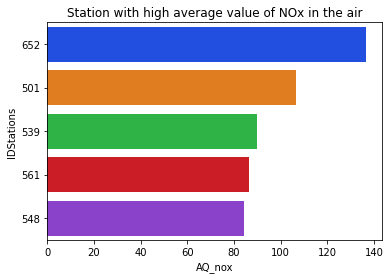

In [24]:
# 5 station that have highest overall amount of NOx in the air
sns.barplot(y=top5_pollution('nox').index, x = 'AQ_nox',data = top5_pollution('nox'))
plt.title('Station with high average value of NOx in the air');

In [25]:
extract_aq_df('nox','652')['AQ_nox'].describe()

count    2157.000000
mean      138.870283
std        82.061550
min        10.610000
25%        80.140000
50%       115.200000
75%       179.700000
max       554.400000
Name: AQ_nox, dtype: float64

In [26]:
extract_aq_df('nox','652')['AQ_nox'].skew()

1.2970630667223808

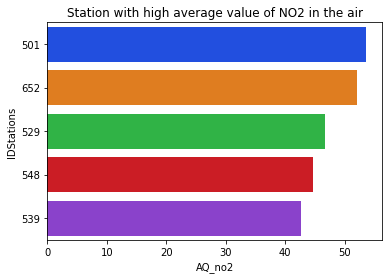

In [27]:
# 5 station that have highest overall amount of NO2 in the air
sns.barplot(y=top5_pollution('no2').index, x = 'AQ_no2',data = top5_pollution('no2'))
plt.title('Station with high average value of NO2 in the air');

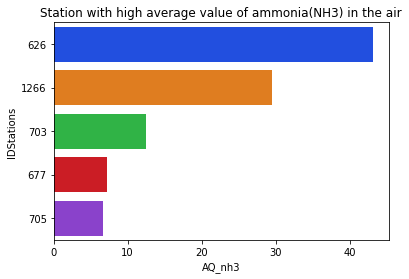

In [28]:
# 5 station that have highest overall amount of NH3 in the air
sns.barplot(y=top5_pollution('nh3').index, x = 'AQ_nh3',data = top5_pollution('nh3'))
plt.title('Station with high average value of ammonia(NH3) in the air');

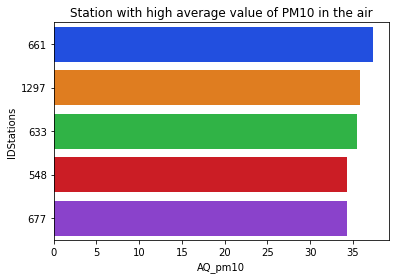

In [29]:
# 5 station that have highest overall amount of pm10 in the air
sns.barplot(y=top5_pollution('pm10').index, x = 'AQ_pm10',data = top5_pollution('pm10'))
plt.title('Station with high average value of PM10 in the air');

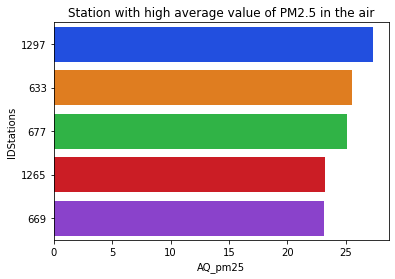

In [30]:
# 5 station that have highest overall amount of pm2.5 in the air
sns.barplot(y=top5_pollution('pm25').index, x = 'AQ_pm25',data = top5_pollution('pm25'))
plt.title('Station with high average value of PM2.5 in the air');

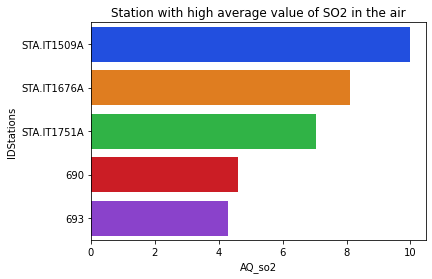

In [31]:
# 5 station that have highest overall amount of SO2 in the air
sns.barplot(y=top5_pollution('so2').index, x = 'AQ_so2',data = top5_pollution('so2'))
plt.title('Station with high average value of SO2 in the air');

In [32]:
# Most station for each air pollution
most_pollution = pd.DataFrame(columns=['IDStations', 'quality', 'Values'])
for i, quality in enumerate(['nox','no2','nh3','pm10','pm25','so2']):
    most_pol_temp = top5_pollution(quality).head(1)
    most_pollution.loc[i] = [most_pol_temp.index[0], quality, most_pol_temp.values[0][0]]

In [33]:
most_pollution

IDStations quality  Values
0          652     nox  136.65
1          501     no2   53.63
2          626     nh3   43.11
3          661    pm10   37.31
4         1297    pm25   27.29
5  STA.IT1509A     so2    9.98

We got the stations which have the most pollution in each air pollution quality, then we decided to select this station for modeling and predicting the air quality. In this project, we choose only 1 station for each air quality. The model we build in this project might be the model architecture for the future project.

**In summary**, we choose station for each pollutants following the analysis in the EDA section.
- Station: 652 for air quality of NO$_{x}$
- Station: 501 for air quality of NO$_{2}$
- Station: 626 for air quality of NH$_{3}$
- Station: 661 for air quality of PM$_{10}$
- Station: 1297 for air quality of PM$_{2.5}$
- Station: STA.IT1509A for air quality of SO$_{2}$

# Modeling and Model evaluation
---
In the modeling and model evaluation section, we used the ordinary time series model which is ARIMA model and advance model such as recurrent neural network model (RNN) and Long short-term memory model (LSTM). This section contains 7 parts.
1. Function using in the modeling section
2. Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652
3. Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501
4. Model for predicting ammonia (NH$_{3}$) quantity of station 626
5. Model for predicting PM$_{10}$ of station 661
6. Model for predicting PM$_{2.5}$ of station 1297
7. Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

The modeling parts will have at least 3 models which are ARIMA, RNN and LSTM model. The train and test data of ARIMA and neural network model will split in the different method.
- For ARIMA model, The test data will be the small size (~5% of the data) because ARIMA model will predict the mean of the data in the long term.
- For RNN and LSTM model, The test data will be the default size of the split in the Scikit-learn (25% of the data).
- The last model for each pollutants may be the RNN or LSTM model and do feature engineering in the model. The feature engineering in this modeling part is dummying the categorical variable and adding the moving average.

The evaluation of the model will be one or more of the below list.
- Score of the model: Mean square error, Akaike Information Critera (for ARIMA model), Mean absolute error percentage[[Ref.]](https://neptune.ai/blog/select-model-for-time-series-prediction-task) and Root mean square error (Which we used to compare between baseline model)
- Ablity for capture the trend in the time series data observed by time series graph
- If there are aqi index for pollutants, we will calculate the accuracy of the model that can predict pollutants correctly. For example, If there are 10 days that have NOx greater than 120 and the model can predict NOx > 120 7 days, The accuracy of the model is 70% for predicting the high pollution days.

## Function using in the modeling section
This part is gathering the function using in the modeling section.
1. Function using for extract/visualize the data
2. Function using in the ARIMA model

### Function using for extract/visualize the data

In [34]:
def station_daily(station, quality, label):
    """Display daily air quality of the given station
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               label: label of y axis
    """
    plt.figure(figsize=(15,6))
    df_temp = extract_aq_df(quality,station)
    plt.plot(df_temp[f'AQ_{quality}'], color='royalblue')
    plt.title(f'Daily {label} quantity of station {station}',fontsize=18)
    plt.ylabel(label, fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.axhline(df_temp[f'AQ_{quality}'].mean(),color='salmon');

### Function using in the ARIMA model

In [35]:
def interpret_dftest(dftest):
    """Check for stationary of the time series data
    -------
    Parameter: Adfuller of extracted dataframe
    Return: Dataframe with Test statistic and p-value
    """
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [36]:
def train_test_time_series(station, quality,test_size=0.1):
    """Split the data for statistic model e.g. ARIMA
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               test_size: float 0 to 1 with default=0.1
    Return: train, test
    """
    train, test = train_test_split(extract_aq_df(quality,station)[f'AQ_{quality}'],
                                       test_size=test_size,
                                       shuffle=False)
    # Assign frequency of data
    train.index = train.index.to_period('d')
    test.index = test.index.to_period('d')
    return train, test

In [37]:
def fit_preds(stat_model, test, show_aic=True, show_mse=True):
    """Fit and Predict value from statistic model e.g. ARIMA
    -------
    Parameter:  stat_model: Instantiate statistic model
                test: test set data 
                show_aic: bool print Akaike Information Critera with default = True
                show_mse: bool print Mean Square Error with default = True
    Return: preds, model.aic, mean_squared_error(test, preds)
    """
    model = stat_model.fit()
    # preds = model.predict(start=train.shape[0], end=(train.shape[0]+test.shape[0]-1))
    preds = model.predict(start=test.index[0], end=test.index[-1])
    if show_aic:
        print(f'AIC: {model.aic}')
    if show_mse:
        print(f'MSE: {mean_squared_error(test, preds)}')
    return preds, model.aic, mean_squared_error(test, preds)

In [38]:
def manual_gridsearch(p_list, d_list, q_list):
    """GridSearch the ARIMA model
    -------
    Parameter:  p, d, q list for gridsearch
    Return: result dataframe from gridsearch
    """
    manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
    count = 0
    for p in p_list:
        for d in d_list:
            for q in q_list:
                ar1 = ARIMA(endog=train, order=(p,d,q))
                preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
                manual_grid.loc[count] = [p, d, q, aic, mse]
                count += 1
    return manual_grid

In [39]:
def station_arima_graph(train, test, preds, quality_title, station):
    """Compare train, test and prediction from ARIMA model
    -------
    Parameter: train: train set
               test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(15,6))

    # Plot training data in blue.
    #plt.plot(train, color = 'royalblue')
    sns.lineplot(x=train.index.to_timestamp(), y=train, color = 'royalblue',label='train')

    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange',label='test')

    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green',label='predict')

    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()
    plt.show();

In [40]:
def test_pred_graph(test, preds, quality_title, station):
    """Compare test and prediction from ARIMA model
    -------
    Parameter: test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(10,6))
    
    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange', label='test')
    
    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green', label='predict')
    
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.legend()
    plt.show();

### Function using in Recurrent Neural Network (RNN) and Long Short-Term memory (LSTM) model

In [41]:
def extract_split(quality, station):
    """Extract dataframe from given condition, define X and y for using in the model and split X and y.
    Note - The extracted dataframe contain only numeric columns.
    Parameter:  quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
                station e.g. '652', 'STA.IT1509A'
    Return: X_train, X_test, y_train, y_test
    """
    data = extract_aq_df(quality,station)
    drop_cols = ['Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
     'AQ_nox','AQ_no2','AQ_so2']
    X = data.select_dtypes(exclude = 'object').drop(columns=drop_cols)
    y = data[f'AQ_{quality}']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        shuffle=False)
    return X_train, X_test, y_train, y_test

In [42]:
def scale_sequences(X_train, X_test, y_train, y_test, length=3):
    """Scale and transform X, y to sequences
    Parameter:  split data: X_train, X_test, y_train, y_test
                length: default = 3
    Return: train_sequences, test_sequences, input_shape
    """
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)

    # Using TimeseriesGenerator to transform the data
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
    test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                        length=length, batch_size=64)
    input_shape = train_sequences[0][0][0].shape
    return train_sequences, test_sequences, input_shape

In [43]:
def compile_fit(model, learning_rate, train_sequences, test_sequences, n_epoch, callbacks,
                verbose=0, loss='mse'):
    """Compile and fit neural network model e.g. RNN and LSTM model.
    -------
    Parameter:  model: Instantiate RNN or LSTM model
                train_sequences, test_sequences: train and test sequence 
                n_epoch: Number of epochs
                callbacks: Callback method e.g. earlystopping
                verbose: default = 'auto'
                loss: loss function default='mse'
    Return: model, history
    """
    model.compile(loss=loss,optimizer=Adam(learning_rate=learning_rate))
    history = model.fit(train_sequences, validation_data=test_sequences,
                        epochs=n_epoch, callbacks=[callbacks], verbose=verbose)
    return model, history

In [44]:
def loss_graph():
    """Plot model loss"""
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend();

In [45]:
def nn_result_graph(quality_title, station, aqi=None, length=3, color='red'):
    """Plot model time series with train, test, predict data
    -------
    Parameter:  quality_title: title showing in the title
                station e.g. '652', 'STA.IT1509A'
                aqi: In case needed to compare to aqi data default = None
                length: parameter from tranforming to sequences default = 3
                color: color of aqi line default = 'red'
    """
    plt.figure(figsize=(15,6))
    sns.lineplot(x=X_train.index, y=y_train, label='train')
    sns.lineplot(x=X_test.index, y=y_test, label='test')
    sns.lineplot(x=X_test.index[length:], y=y_preds[:,0], label='predict')
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()
    if aqi != None:
        plt.axhline(aqi,color=color);

In [46]:
def tuning_graph(quality_title, station, aqi=None, length=3, color='red'):
    plt.figure(figsize=(15,6))
    sns.lineplot(x=X_test.index, y=y_test, label='test')
    sns.lineplot(x=X_test.index[length:], y=y_preds[:,0], label='predict')
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()

In [311]:
def model_error(length=3):
    """Loss, MAPE of training and testing"""
    training_loss = round(model.evaluate(train_sequences, verbose=0),2)
    testing_loss = round(model.evaluate(test_sequences, verbose=0),2)
    mape = round(mean_absolute_percentage_error(y_test[length:],y_preds)*100,2)
    baseline_rmse = round(mean_squared_error([y_train.mean() for n in range(len(y_preds))],y_preds,squared=False),2)
    rmse = round(mean_squared_error(y_test[length:],y_preds,squared=False),2)
    print(f'Loss function: {model.loss}')
    print(f'Training loss: {training_loss}')
    print(f'Testing loss: {testing_loss}')
    print(f'MAPE: {mape}')
    print(f'Baseline RMSE: {baseline_rmse}')
    print(f'RMSE: {rmse}')
    return [training_loss, testing_loss, mape, baseline_rmse, rmse]

In [518]:
def air_exceed_threshold(y_test, y_preds, quality, aqi):
    performance = pd.DataFrame(y_test.iloc[3:])
    performance['pred'] = y_preds
    poor_air = performance[performance[f'AQ_{quality}'] > aqi].copy()
    poor_air['pred_poor'] = (poor_air['pred'] > aqi).astype(int)
    days_gt_aqi = poor_air.shape[0]
    preds_gt_aqi = poor_air['pred_poor'].sum()
    percentage_preds = round(preds_gt_aqi/days_gt_aqi*100,2)
    print(f"Number of days having {quality} > {aqi}: {days_gt_aqi}")
    print(f"Number of days predict {quality} > {aqi}: {preds_gt_aqi}")
    print(f"Predict {quality} > {aqi}: {percentage_preds}%")
    return [days_gt_aqi, preds_gt_aqi, percentage_preds]

## Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652

### ARIMA model

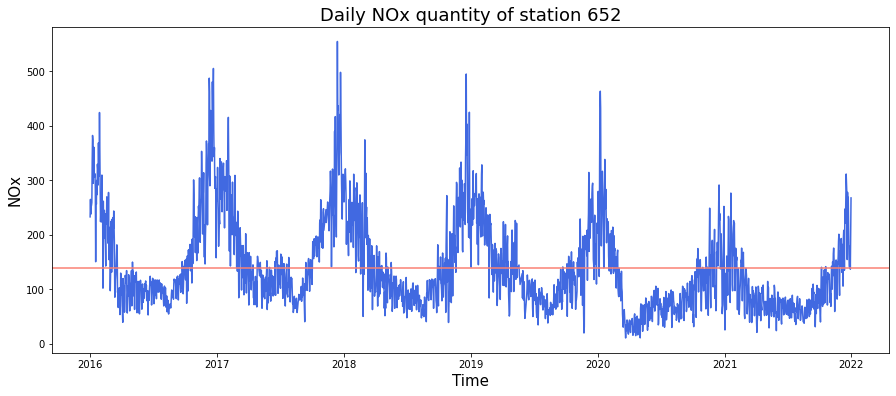

In [49]:
# NOx quantity of station 652
station_daily(station ='652',
              quality='nox',
              label='NOx')

Autocorrelation additional information: 
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/m
- https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Parial Autocorrelation additional information:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

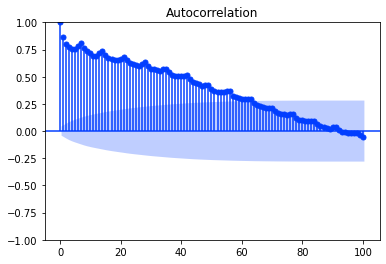

In [50]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=100);

(0.0, 20.0)

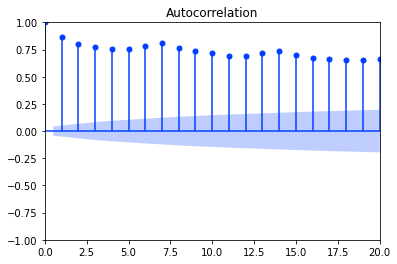

In [51]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=400);
plt.xlim(0,20)

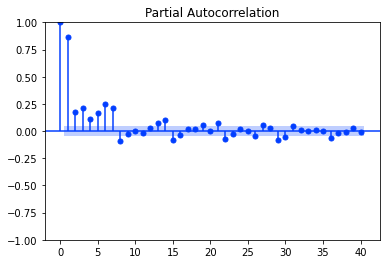

In [52]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('nox','652')['AQ_nox'],lags=40, method='ywm');

In [53]:
# adfuller for checking the trend of station's 652 data
interpret_dftest(adfuller(extract_aq_df('nox','652')['AQ_nox'].dropna()))
# No trend

Test Statistic   -3.447531
p-value           0.009441
dtype: float64

In [54]:
train, test = train_test_time_series('652', 'nox',test_size=0.05) 

In [55]:
type(train)

pandas.core.series.Series

In [56]:
train.shape, test.shape

((2049,), (108,))

In [57]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(10,0,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 20426.190557941904
MSE: 3249.735923551522


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


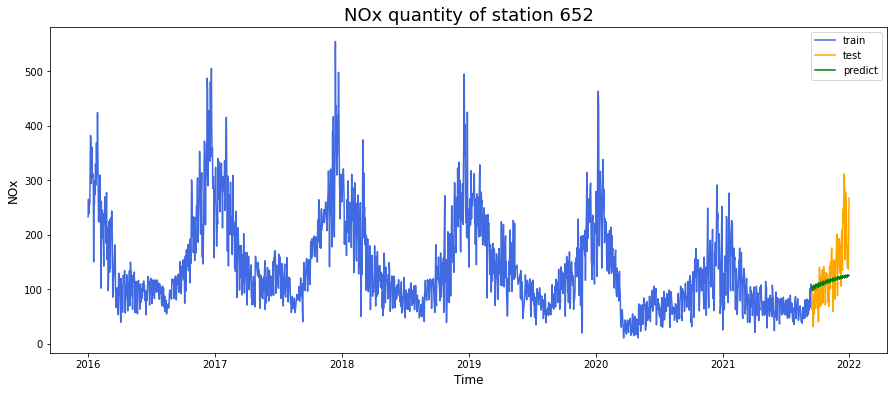

In [58]:
station_arima_graph(train, test, preds,'NOx','652')

In [59]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/nox_arima_gridsearch.csv',index=False)

In [60]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nox_arima_gridsearch.csv')

In [61]:
manual_grid.sort_values('mse').head()

p    d    q           aic          mse
18  8.0  0.0  8.0  20421.192271  3131.433324
26  9.0  0.0  8.0  20425.767966  3134.724902
27  9.0  0.0  9.0  20422.122378  3316.109884
0   6.0  0.0  6.0  20470.080954  3351.673203
9   7.0  0.0  7.0  20456.101769  3450.973592

In [62]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,8))
preds, aic, mse = fit_preds(ar1, test)
mean_absolute_percentage_error(test, preds)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 20421.192271111875
MSE: 3131.433323838929


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.3151907297361658

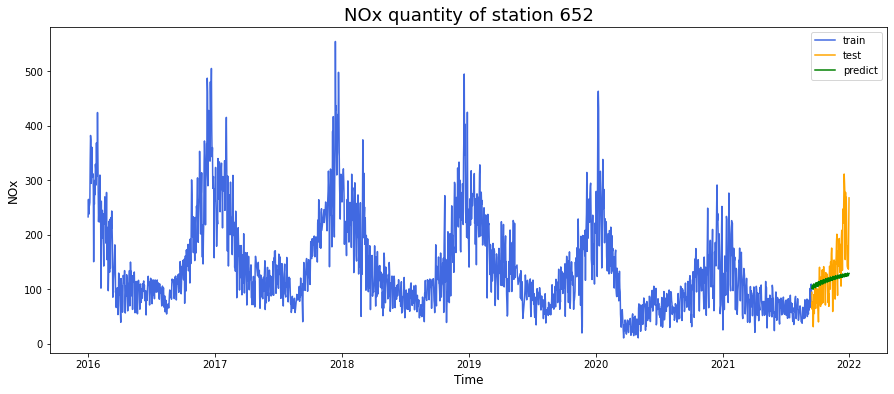

In [63]:
station_arima_graph(train, test, preds,'NOx','652')

### RNN model

In [64]:
X_train, X_test, y_train, y_test = extract_split('nox', '652')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [65]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [66]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 8766.61
Testing loss: 2406.83
MAPE: 50.28
Baseline RMSE: 58.97
RMSE: 49.04


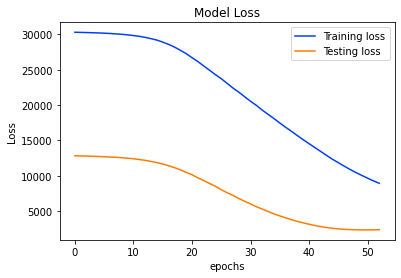

In [67]:
loss_graph()
model_error()

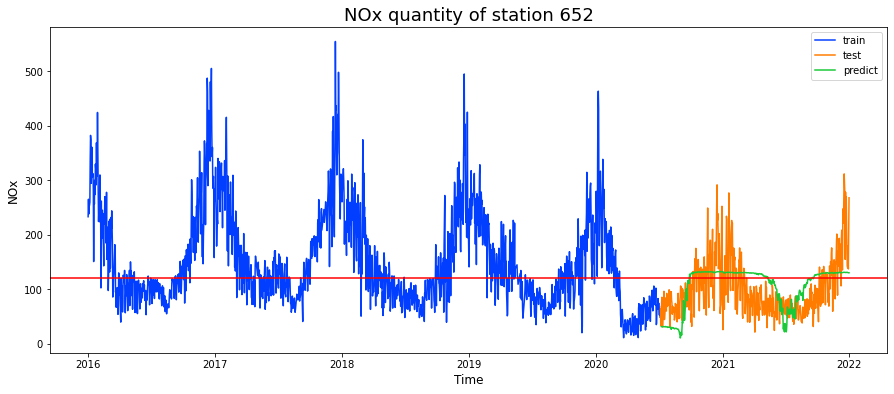

In [68]:
nn_result_graph('NOx', '652', aqi=120)

In [69]:
y_preds.shape, y_test.shape

((537, 1), (540,))

In [70]:
# Check amount of days that have nox in air quality > 120 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'nox', 120)

Number of days having nox > 120: 153
Number of days predict nox > 120: 153
Predict nox > 120: 100.0%


### LSTM model
- [LSTM Example](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- **ELU activation** is very similiar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes. [[Ref.]](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=ELU%20is%20very%20similiar%20to,%CE%B1%20whereas%20RELU%20sharply%20smoothes.&text=Pros-,ELU%20becomes%20smooth%20slowly%20until%20its%20output%20equal,%CE%B1%20whereas%20RELU%20sharply%20smoothes.)

In [71]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [72]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 2974.54
Testing loss: 2481.23
MAPE: 50.03
Baseline RMSE: 55.9
RMSE: 49.8


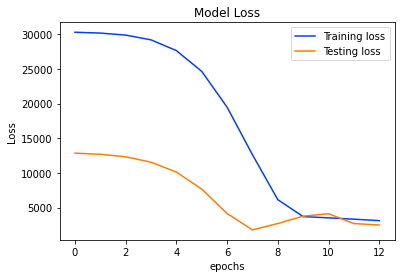

In [73]:
loss_graph()
model_error()

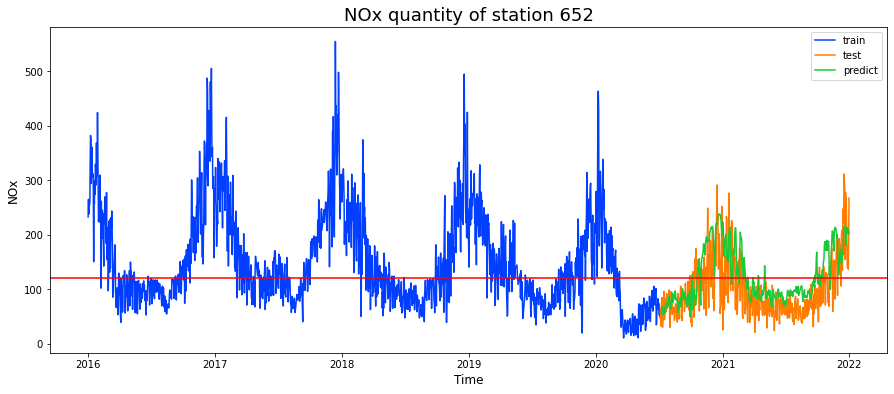

In [74]:
nn_result_graph('NOx', '652', aqi=120)

In [75]:
# Check amount of days that have nox in air quality > 120 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'nox', 120)

Number of days having nox > 120: 153
Number of days predict nox > 120: 138
Predict nox > 120: 90.2%


### LSTM model with feature engineering

In [76]:
df.select_dtypes(include='object').columns

Index(['IDStations', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m'],
      dtype='object')

In [77]:
data = extract_aq_df('nox','652')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling15_nox'] = data['AQ_nox'].rolling(window=15).mean()
data['rolling30_nox'] = data['AQ_nox'].rolling(window=30).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nox']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [78]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [79]:
# Design LSTM
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0005)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0005)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0005)))


# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
# model, history = compile_fit(model, 0.0005, 
#                              train_sequences, test_sequences,
#                              100, es)

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.00015, 
                             train_sequences, test_sequences,
                             100, es, loss='mean_absolute_error')

In [80]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [81]:
mean_squared_error(y_test[3:],y_preds)

3223.4710413156754

Loss function: mean_absolute_error
Training loss: 35.49
Testing loss: 41.96
MAPE: 39.72
Baseline RMSE: 87.36
RMSE: 56.78


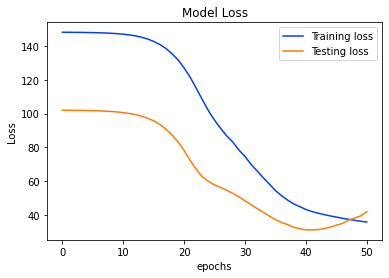

In [82]:
loss_graph()
model_error()

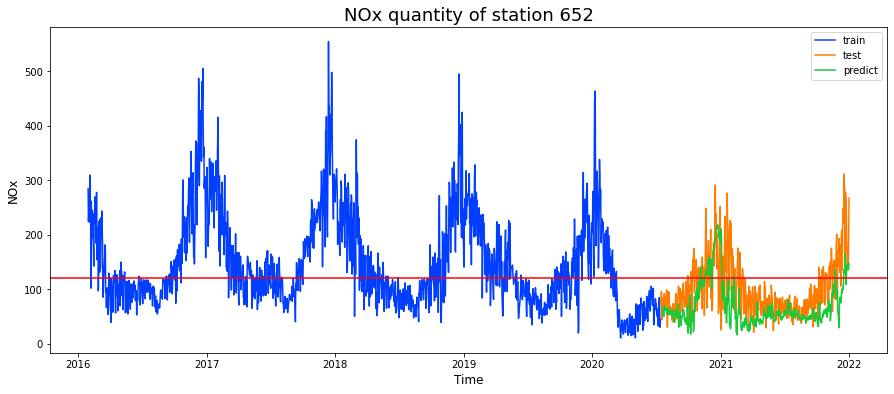

In [83]:
nn_result_graph('NOx', '652', aqi=120)

In [84]:
# Check amount of days that have nox in air quality > 120 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'nox', 120)

Number of days having nox > 120: 153
Number of days predict nox > 120: 50
Predict nox > 120: 32.68%


## Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501

### ARIMA model

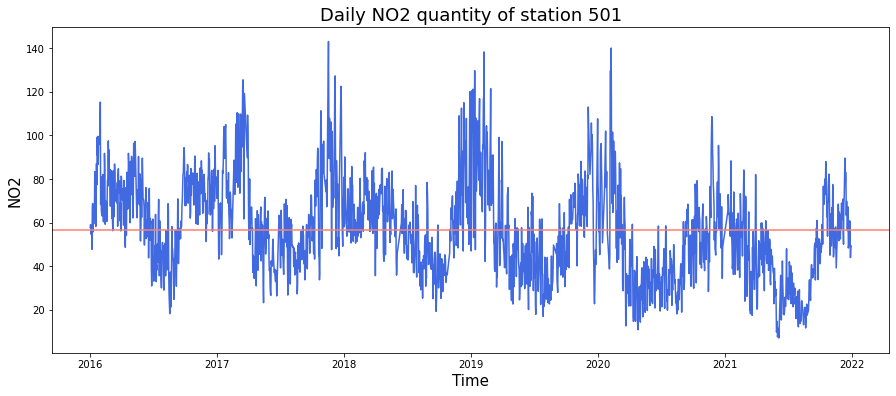

In [85]:
station_daily(station ='501',
              quality='no2',
              label='NO2')

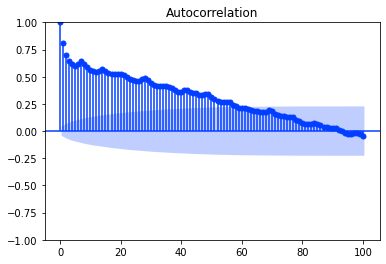

In [86]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=100);

(0.0, 20.0)

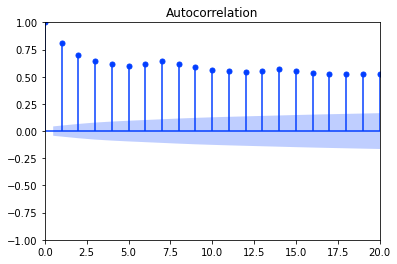

In [87]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=400);
plt.xlim(0,20)

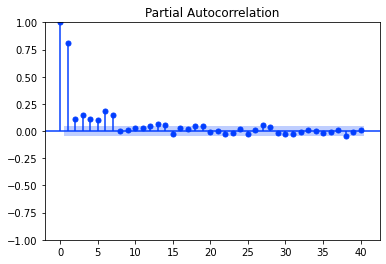

In [88]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('no2','501')['AQ_no2'],lags=40,method='ywm');

In [89]:
# adfuller for checking the trend of station's 501 data
interpret_dftest(adfuller(extract_aq_df('no2','501')['AQ_no2'].dropna()))
# No trend

Test Statistic   -3.685998
p-value           0.004314
dtype: float64

In [90]:
train, test = train_test_time_series('501', 'no2',test_size=0.05)
train.shape, test.shape

((1965,), (104,))

In [91]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [92]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15611.48998215408
MSE: 171.9746066755182


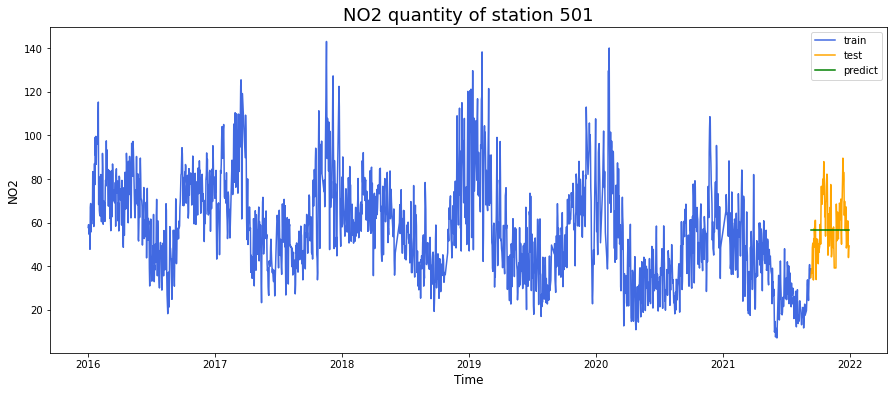

In [93]:
station_arima_graph(train, test, preds, 'NO2', '501')

In [94]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/no2_arima_gridsearch.csv',index=False)

In [95]:
manual_grid = pd.read_csv('./saved_data/no2_arima_gridsearch.csv')

In [96]:
manual_grid.sort_values('mse').head()

p    d    q           aic         mse
16  8.0  0.0  6.0  15382.837409  171.968557
24  9.0  0.0  6.0  15387.214844  173.317828
0   6.0  0.0  6.0  15384.586456  173.698826
27  9.0  0.0  9.0  15373.899422  174.402237
1   6.0  0.0  7.0  15383.276898  175.619961

In [97]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,6))
preds, aic, mse = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 15382.837408521322
MSE: 171.96855673365775


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


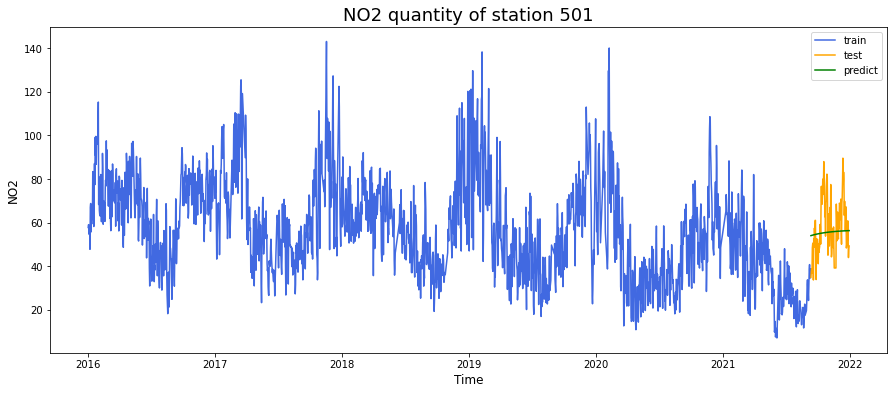

In [98]:
station_arima_graph(train, test, preds, 'NO2', '501')

ARIMA model can't capture trend of the series.

### RNN model

In [99]:
X_train, X_test, y_train, y_test = extract_split('no2', '501')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [100]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [101]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


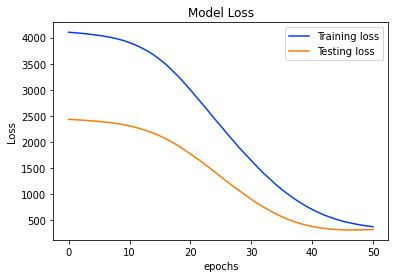

In [102]:
loss_graph()

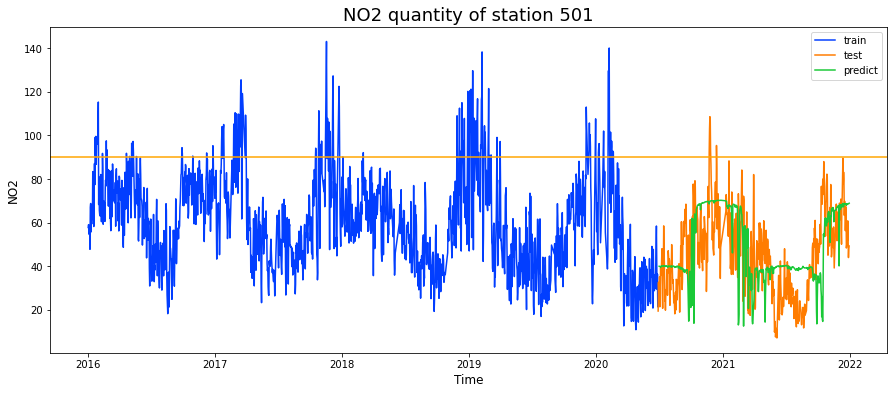

In [103]:
nn_result_graph('NO2', '501', 90, color='orange')

In [104]:
# Check amount of days that have no2 in air quality > 90 (index level: medium)
air_exceed_threshold(y_test, y_preds, 'no2', 90)

Number of days having no2 > 90: 6
Number of days predict no2 > 90: 0
Predict no2 > 90: 0.0%


### LSTM model

In [105]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [106]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 224.11
Testing loss: 281.1
MAPE: 34.57
Baseline RMSE: 22.14
RMSE: 16.77


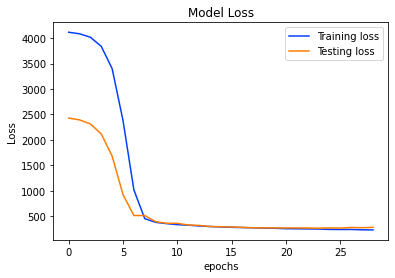

In [107]:
loss_graph()
model_error()

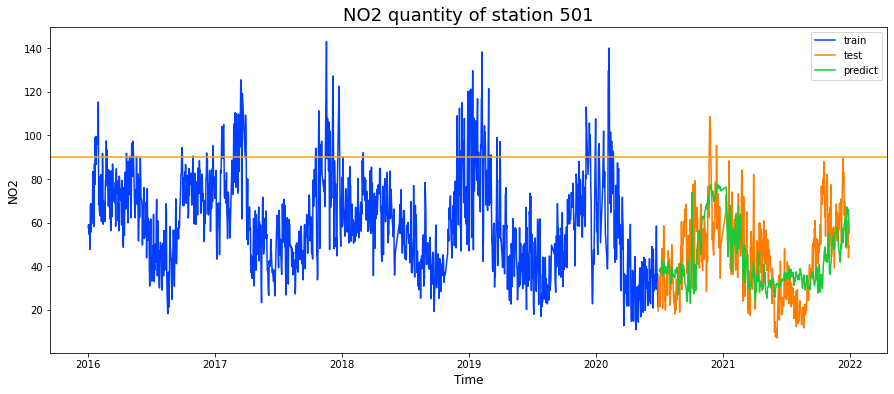

In [108]:
nn_result_graph('NO2', '501', aqi=90, color='orange')

In [109]:
# Check amount of days that have no2 in air quality > 90 (index level: medium)
air_exceed_threshold(y_test, y_preds, 'no2', 90)

Number of days having no2 > 90: 6
Number of days predict no2 > 90: 0
Predict no2 > 90: 0.0%


### LSTM model with feature engineering

In [110]:
data = extract_aq_df('no2','501')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_no2'] = data['AQ_no2'].rolling(window=12).mean()
data['rolling14_no2'] = data['AQ_no2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_no2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [111]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [112]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es, loss='mean_absolute_error')

In [113]:
# 4. Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


Loss function: mean_absolute_error
Training loss: 10.94
Testing loss: 12.84
MAPE: 36.79
Baseline RMSE: 18.18
RMSE: 15.77


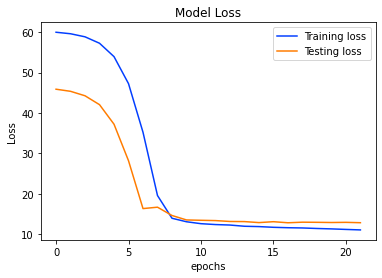

In [114]:
loss_graph()
model_error()

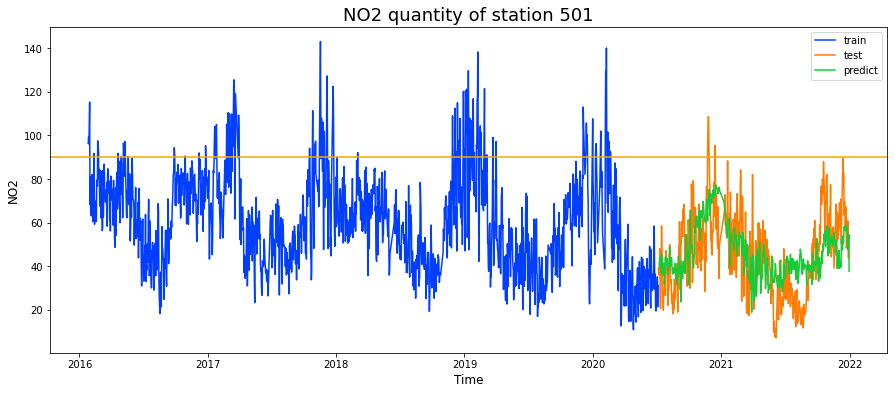

In [115]:
nn_result_graph('NO2', '501', aqi=90, color='orange')

In [116]:
# Check amount of days that have no2 in air quality > 90 (index level: medium)
air_exceed_threshold(y_test, y_preds, 'no2', 90)

Number of days having no2 > 90: 6
Number of days predict no2 > 90: 0
Predict no2 > 90: 0.0%


## Model for predicting ammonia (NH$_{3}$) quantity of station 626

### ARIMA model

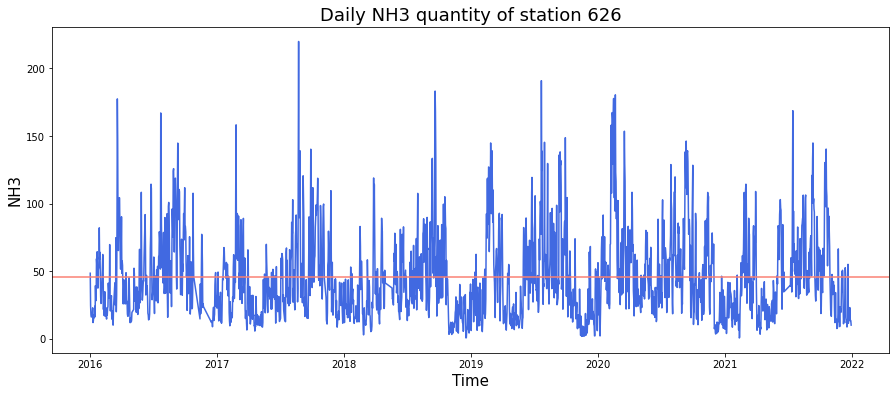

In [117]:
station_daily(station ='626',
              quality='nh3',
              label='NH3')

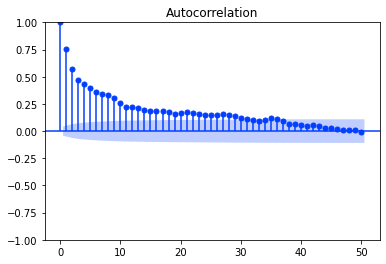

In [118]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nh3','626')['AQ_nh3'],lags=50);

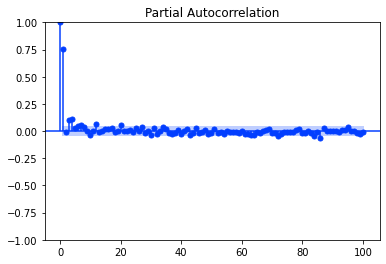

In [119]:
plot_pacf(extract_aq_df('nh3','626')['AQ_nh3'],lags=100,method='ywm');

In [120]:
# adfuller for checking the trend of station's 626 data
interpret_dftest(adfuller(extract_aq_df('nh3','626')['AQ_nh3'].dropna()))
# No trend

Test Statistic   -8.002906e+00
p-value           2.308297e-12
dtype: float64

In [121]:
train, test = train_test_time_series('626', 'nh3',test_size=0.05)
train.shape, test.shape

((1976,), (105,))

In [122]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [123]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 17638.603903284828
MSE: 926.3524393807932


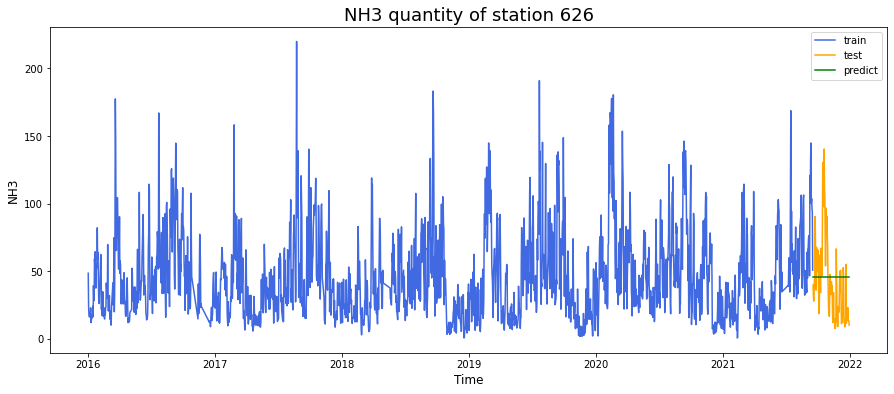

In [124]:
station_arima_graph(train, test, preds, 'NH3', '626')

In [125]:
# Manual Gridsearch
# p_list = [p for p in range(1,10)]
# d_list = [0, 1]
# q_list = [q for q in range(1,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/nh3_arima_gridsearch.csv',index=False)

In [126]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nh3_arima_gridsearch.csv')

In [127]:
manual_grid.sort_values('aic').head()

p    d    q           aic         mse
31   2.0  1.0  5.0  17582.021458  927.239198
12   1.0  1.0  4.0  17584.888375  927.726383
13   1.0  1.0  5.0  17586.901045  928.176502
154  9.0  1.0  2.0  17587.177698  927.202231
136  8.0  1.0  2.0  17588.513554  927.078812

### RNN Model

In [128]:
X_train, X_test, y_train, y_test = extract_split('nh3', '626')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [129]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(64, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [130]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 624.19
Testing loss: 918.98
MAPE: 123.84
Baseline RMSE: 15.09
RMSE: 30.31


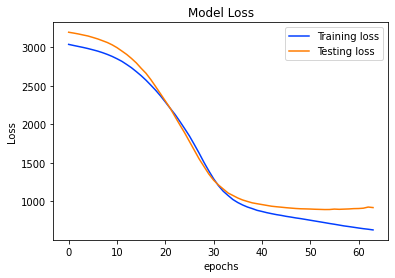

In [131]:
loss_graph()
model_error()

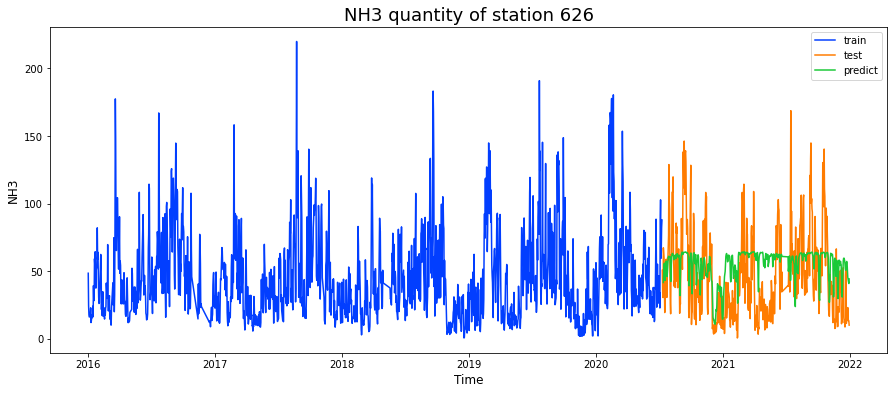

In [132]:
nn_result_graph('NH3', '626')

### LSTM model

In [133]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [134]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 674.28
Testing loss: 899.31
MAPE: 121.12
Baseline RMSE: 14.11
RMSE: 29.99


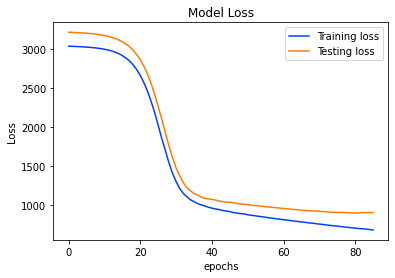

In [135]:
loss_graph()
model_error()

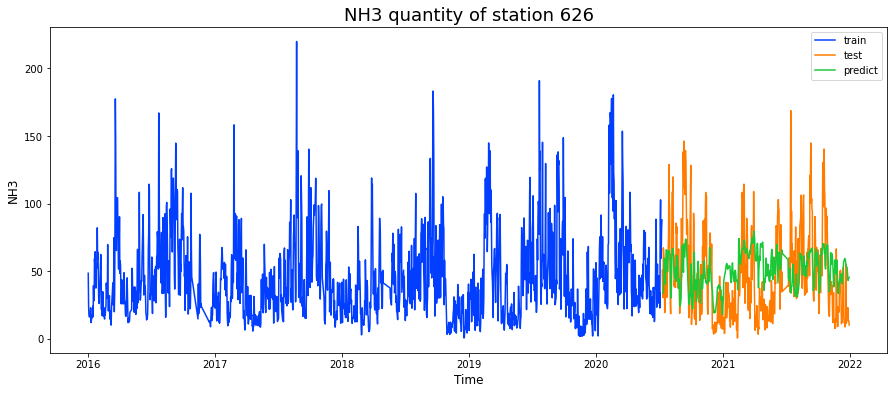

In [136]:
nn_result_graph('NH3', '626')

### LSTM model with feature engineering

In [137]:
data = extract_aq_df('nh3','626')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_nh3'] = data['AQ_nh3'].rolling(window=15).mean()
data['rolling26_nh3'] = data['AQ_nh3'].rolling(window=30).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nh3']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [138]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [139]:
# Design LSTM
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
# Change loss function to mean absolute error
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es, loss='mean_absolute_error')

In [140]:
# 4. Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


In [141]:
mean_squared_error(y_test[3:],y_preds)

699.7684692953059

Loss function: mean_absolute_error
Training loss: 12.27
Testing loss: 20.98
MAPE: 92.44
Baseline RMSE: 23.84
RMSE: 26.45


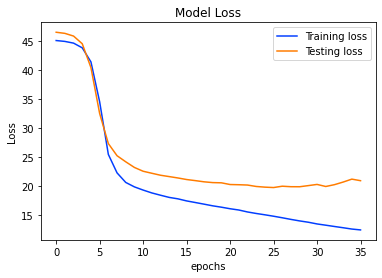

In [142]:
loss_graph()
model_error()

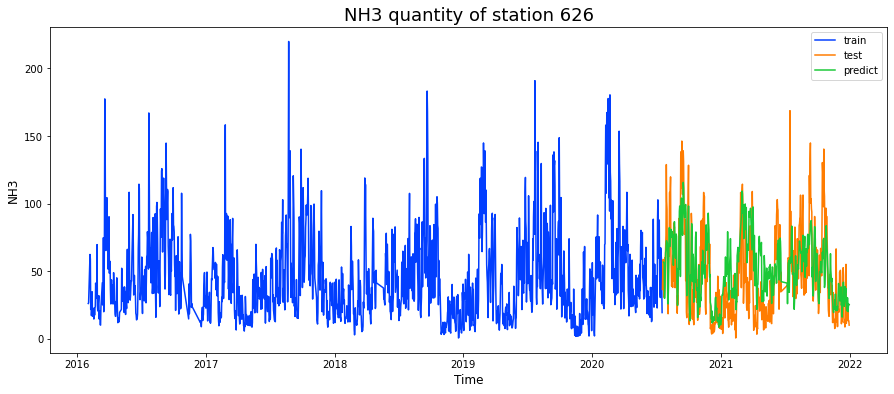

In [143]:
nn_result_graph('NH3', '626')

## Model for predicting PM$_{10}$ of station 661

### ARIMA model

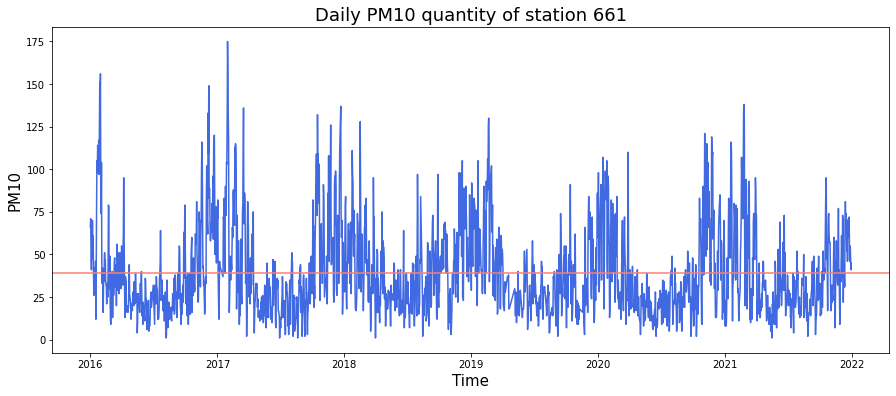

In [144]:
station_daily(station ='661',
              quality='pm10',
              label='PM10')

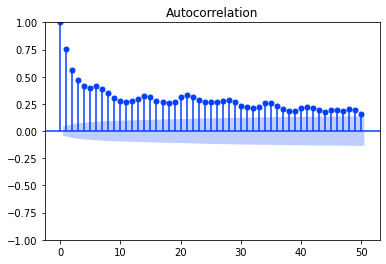

In [145]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('pm10','661')['AQ_pm10'],lags=50);

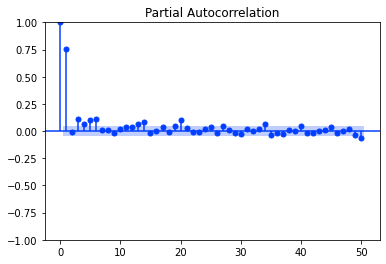

In [146]:
plot_pacf(extract_aq_df('pm10','661')['AQ_pm10'],lags=50,method='ywm');

In [147]:
# adfuller for checking the trend of station's 661 data
interpret_dftest(adfuller(extract_aq_df('pm10','661')['AQ_pm10'].dropna()))
# No trend

Test Statistic   -5.014854
p-value           0.000021
dtype: float64

In [148]:
train, test = train_test_time_series('661', 'pm10',test_size=0.05)
train.shape, test.shape

((1976,), (104,))

In [149]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [150]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 16857.709597079564
MSE: 376.90077558924753


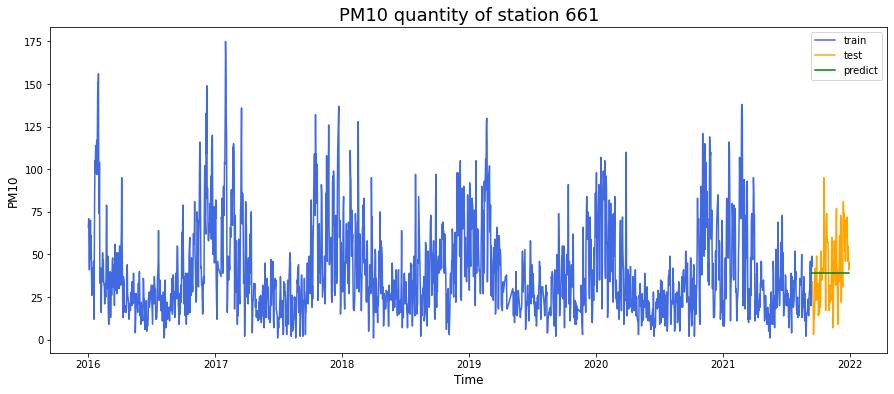

In [151]:
station_arima_graph(train, test, preds, 'PM10', '661')

In [152]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/pm10_arima_gridsearch.csv',index=False)

In [153]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/pm10_arima_gridsearch.csv')

In [154]:
manual_grid.sort_values('aic').head()

p    d     q           aic         mse
139   7.0  1.0  10.0  16730.217495  535.114448
199  10.0  1.0  10.0  16732.315462  531.225647
159   8.0  1.0  10.0  16735.072123  536.668627
118   6.0  1.0   9.0  16737.934705  530.820468
198  10.0  1.0   9.0  16738.711732  539.050847

In [155]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(7,1,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 16730.21749504151
MSE: 535.1144484772203


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


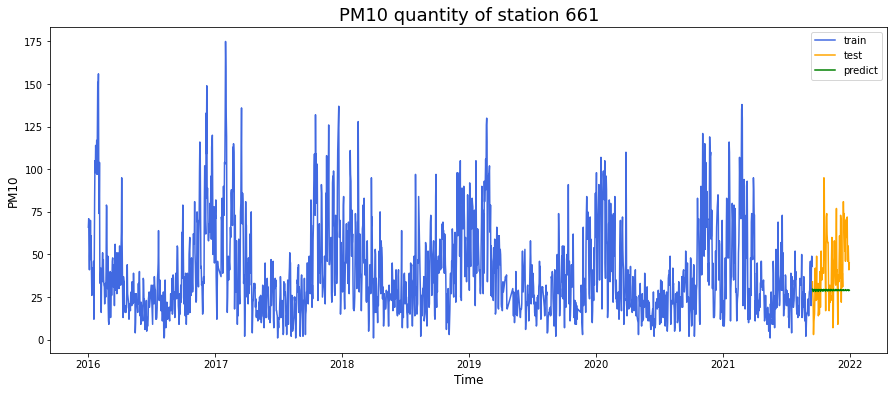

In [156]:
station_arima_graph(train, test, preds, 'PM10', '661')

### RNN Model

In [157]:
X_train, X_test, y_train, y_test = extract_split('pm10', '661')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [158]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [159]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 331.06
Testing loss: 395.3
MAPE: 58.71
Baseline RMSE: 14.86
RMSE: 19.88


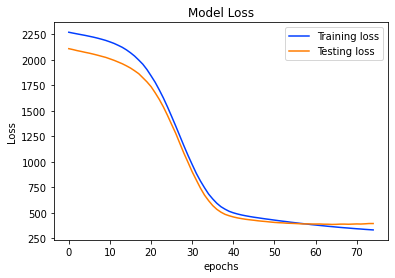

In [160]:
loss_graph()
model_error()

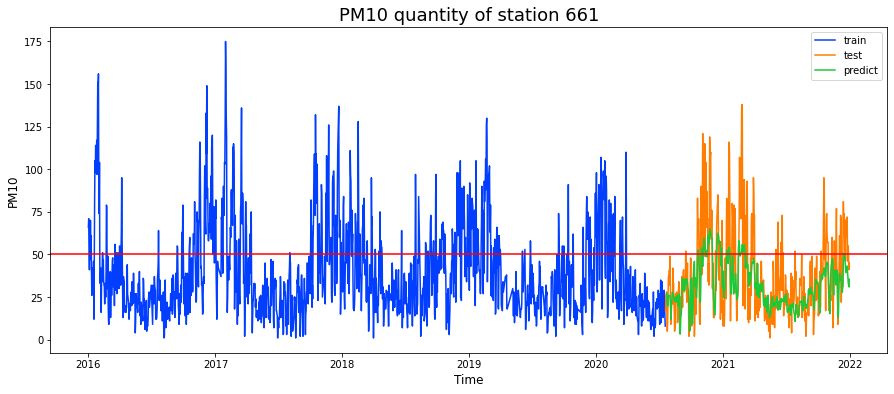

In [161]:
nn_result_graph('PM10', '661', aqi=50)

In [162]:
# Check amount of days that have pm10 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm10', 50)

Number of days having pm10 > 50: 128
Number of days predict pm10 > 50: 53
Predict pm10 > 50: 41.41%


### LSTM model

In [163]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [164]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 363.09
Testing loss: 416.11
MAPE: 61.64
Baseline RMSE: 15.49
RMSE: 20.4


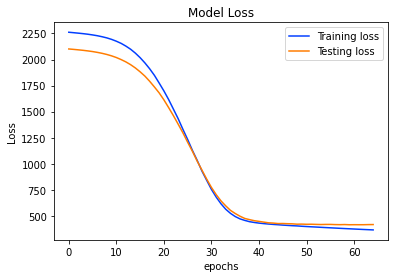

In [165]:
loss_graph()
model_error()

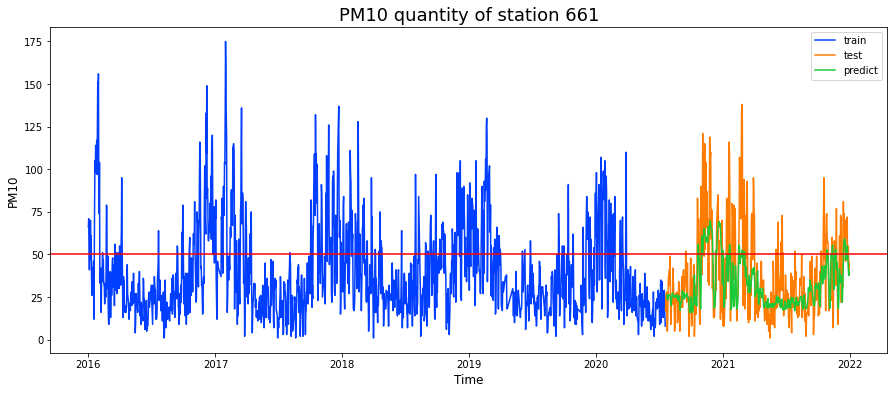

In [166]:
nn_result_graph('PM10', '661', aqi=50)

In [167]:
# Check amount of days that have pm10 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm10', 50)

Number of days having pm10 > 50: 128
Number of days predict pm10 > 50: 53
Predict pm10 > 50: 41.41%


### LSTM model with feature engineering

In [168]:
data = extract_aq_df('pm10','661')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_pm10'] = data['AQ_pm10'].rolling(window=7).mean()
data['rolling15_pm10'] = data['AQ_pm10'].rolling(window=12).mean()
data['rolling30_pm10'] = data['AQ_pm10'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm10']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [169]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [170]:
# Design LSTM
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.005, 
                             train_sequences, test_sequences,
                             100, es, loss='mean_absolute_error')

In [171]:
# 4. Prediction
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


Loss function: mean_absolute_error
Training loss: 8.93
Testing loss: 15.54
MAPE: 54.5
Baseline RMSE: 18.45
RMSE: 20.74


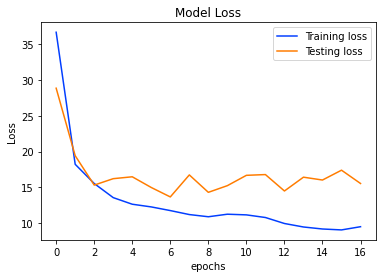

In [172]:
loss_graph()
model_error()

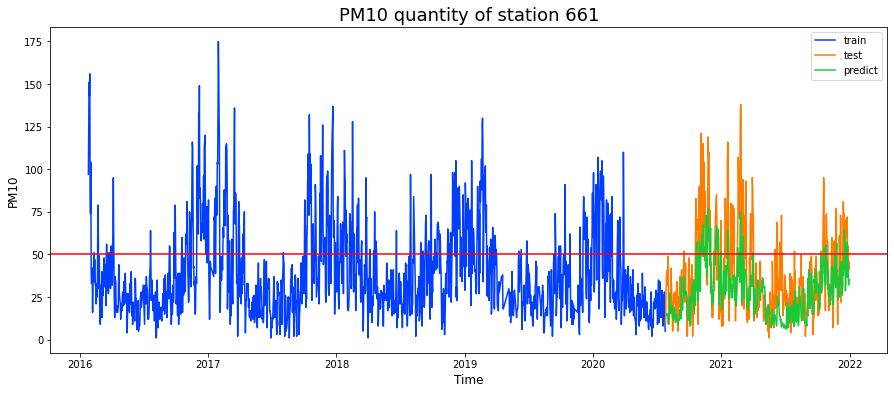

In [173]:
nn_result_graph('PM10', '661', aqi=50)

In [174]:
# Check amount of days that have pm10 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm10', 50)

Number of days having pm10 > 50: 128
Number of days predict pm10 > 50: 50
Predict pm10 > 50: 39.06%


## Model for predicting PM$_{2.5}$ of station 1297

### ARIMA model

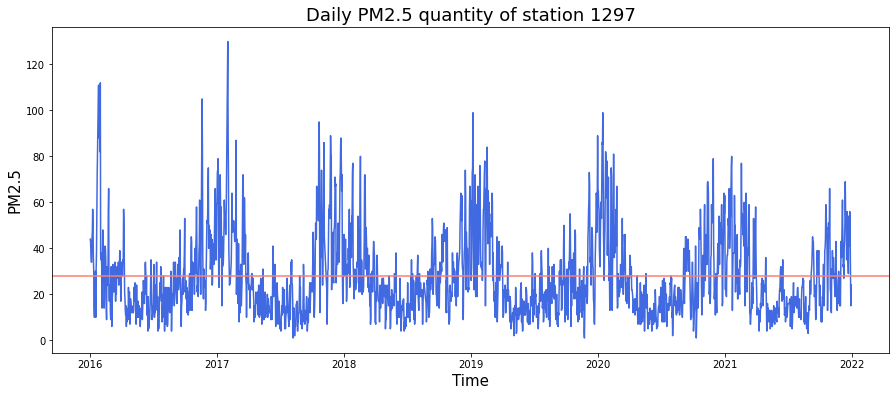

In [175]:
station_daily(station ='1297',
              quality='pm25',
              label='PM2.5')

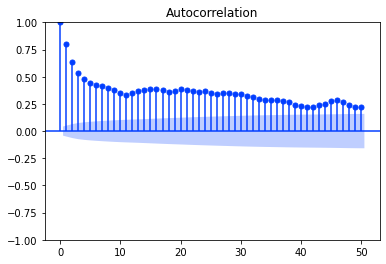

In [176]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('pm25','1297')['AQ_pm25'],lags=50);

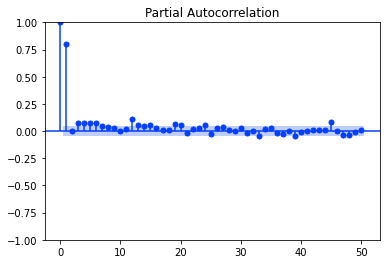

In [177]:
plot_pacf(extract_aq_df('pm25','1297')['AQ_pm25'],lags=50,method='ywm');

In [178]:
# adfuller for checking the trend of station's 1297 data
interpret_dftest(adfuller(extract_aq_df('pm25','1297')['AQ_pm25'].dropna()))
# No trend

Test Statistic   -4.131121
p-value           0.000860
dtype: float64

In [179]:
train, test = train_test_time_series('1297', 'pm25',test_size=0.05)
train.shape, test.shape

((2044,), (108,))

In [180]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [181]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15589.541996871529
MSE: 213.66118797566762


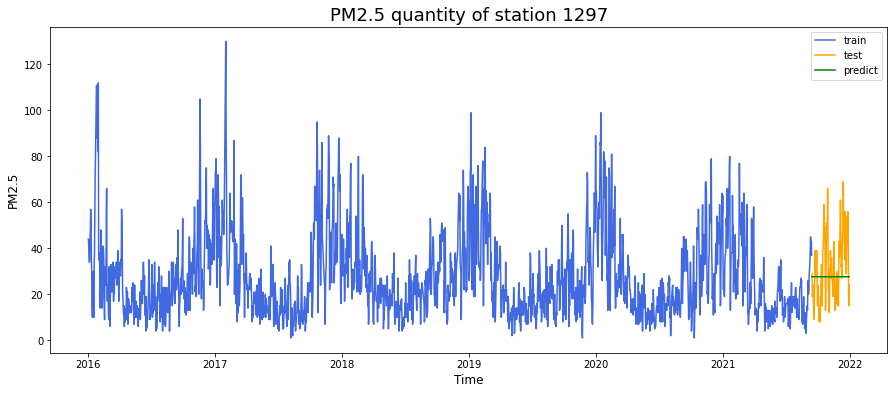

In [182]:
station_arima_graph(train, test, preds, 'PM2.5', '1297')

In [183]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/pm25_arima_gridsearch.csv',index=False)

In [184]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/pm25_arima_gridsearch.csv')

In [185]:
manual_grid.sort_values('aic').head()

p    d     q           aic         mse
79   4.0  1.0  10.0  15487.621117  241.540963
175  9.0  1.0   6.0  15490.344376  244.057467
89   5.0  0.0  10.0  15490.984165  218.458417
136  7.0  1.0   7.0  15491.202643  241.835549
156  8.0  1.0   7.0  15491.884511  241.304214

In [186]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(4,1,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15487.621116967617
MSE: 241.5409630299658


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


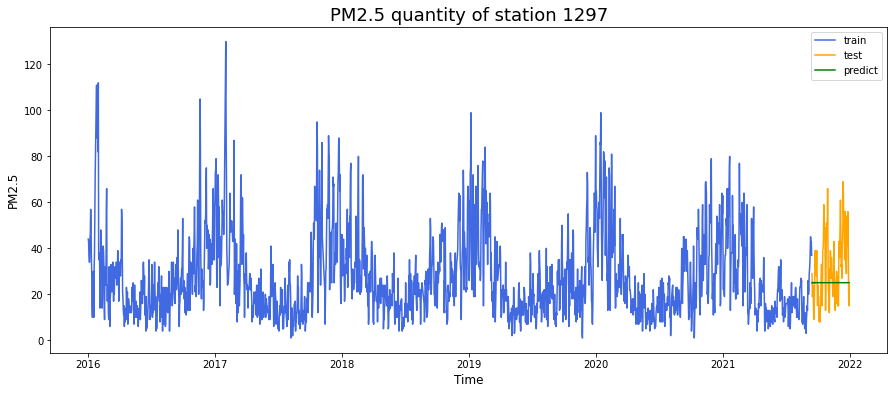

In [187]:
station_arima_graph(train, test, preds, 'PM2.5', '1297')

### RNN Model

In [188]:
X_train, X_test, y_train, y_test = extract_split('pm25', '1297')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [189]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es)

In [190]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 97.58
Testing loss: 116.89
MAPE: 48.67
Baseline RMSE: 12.54
RMSE: 10.81


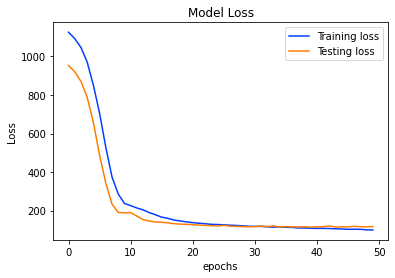

In [191]:
loss_graph()
model_error()

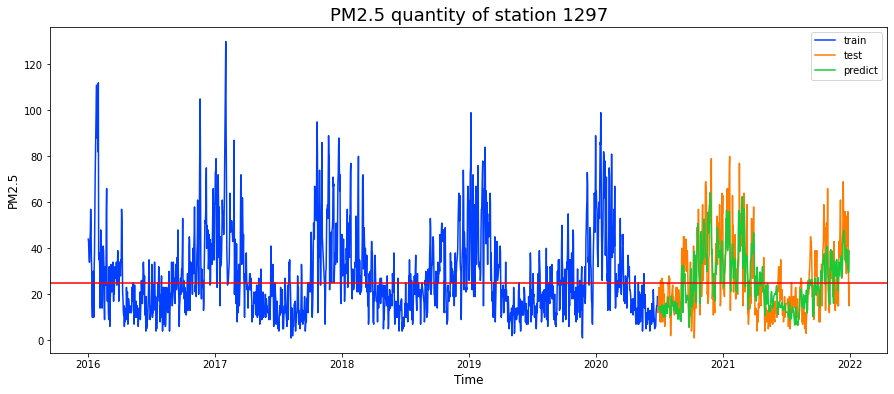

In [192]:
nn_result_graph('PM2.5', '1297', aqi=25)

In [193]:
# Check amount of days that have pm2.5 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm25', 50)

Number of days having pm25 > 50: 54
Number of days predict pm25 > 50: 13
Predict pm25 > 50: 24.07%


### LSTM model

In [194]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.001, 
                             train_sequences, test_sequences,
                             150, es)

In [195]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 152.66
Testing loss: 231.19
MAPE: 89.85
Baseline RMSE: 13.65
RMSE: 15.2


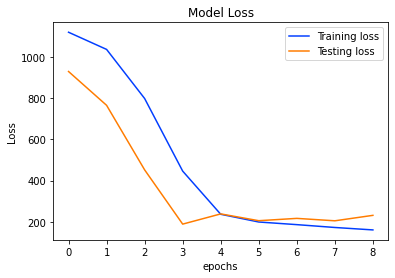

In [196]:
loss_graph()
model_error()

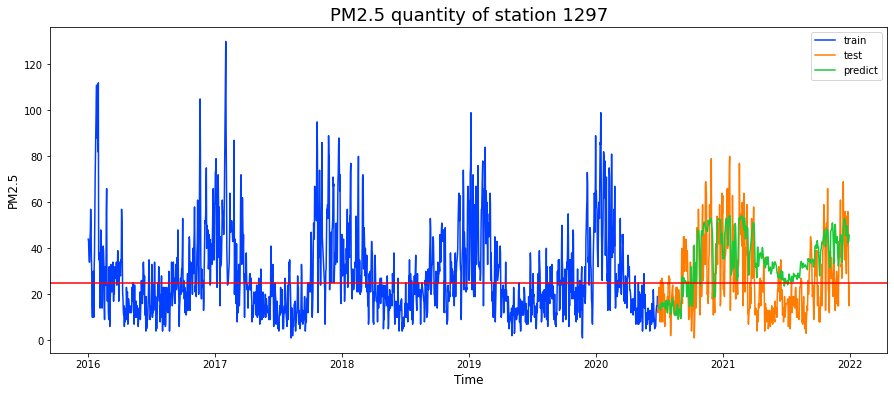

In [197]:
nn_result_graph('PM2.5', '1297', aqi=25)

In [198]:
# Check amount of days that have pm2.5 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm25', 50)

Number of days having pm25 > 50: 54
Number of days predict pm25 > 50: 27
Predict pm25 > 50: 50.0%


### RNN model with feature engineering

In [199]:
data = extract_aq_df('pm25','1297')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_pm25'] = data['AQ_pm25'].rolling(window=12).mean()
data['rolling26_pm25'] = data['AQ_pm25'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm25']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [200]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [201]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es, loss='mean_absolute_error')

In [202]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [203]:
mean_squared_error(y_test[3:],y_preds)

117.64720726743344

Loss function: mean_absolute_error
Training loss: 5.42
Testing loss: 8.12
MAPE: 43.45
Baseline RMSE: 14.03
RMSE: 10.85


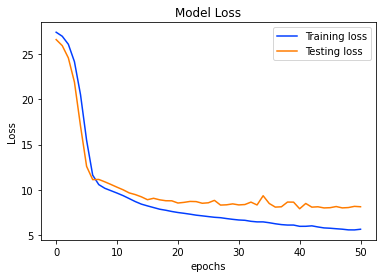

In [204]:
loss_graph()
model_error()

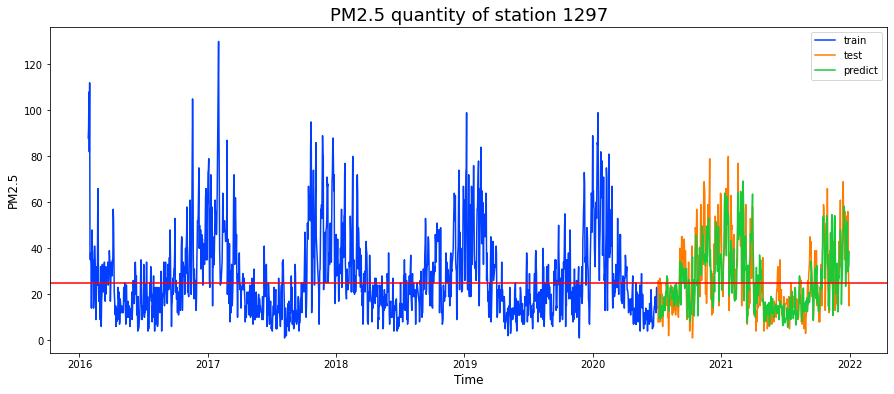

In [205]:
nn_result_graph('PM2.5', '1297', aqi=25)

In [206]:
# Check amount of days that have pm2.5 in air quality > 50 (index level: poor)
air_exceed_threshold(y_test, y_preds, 'pm25', 50)

Number of days having pm25 > 50: 54
Number of days predict pm25 > 50: 19
Predict pm25 > 50: 35.19%


## Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

### ARIMA model

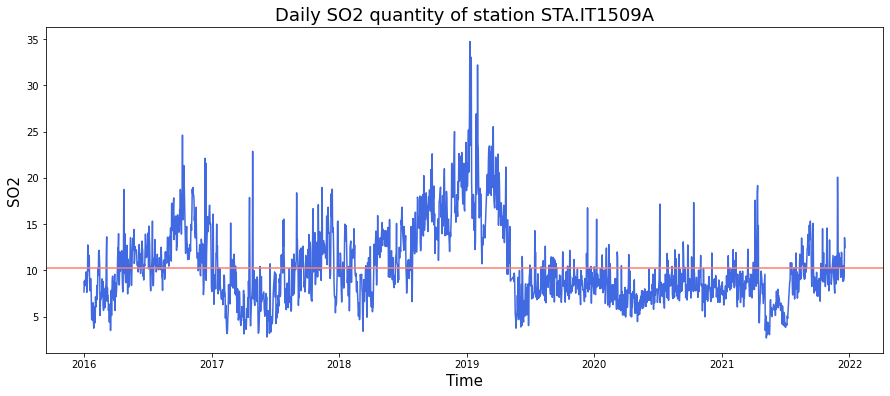

In [207]:
station_daily(station ='STA.IT1509A',
              quality='so2',
              label='SO2')

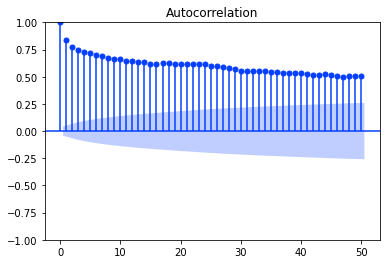

In [208]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('so2','STA.IT1509A')['AQ_so2'],lags=50);

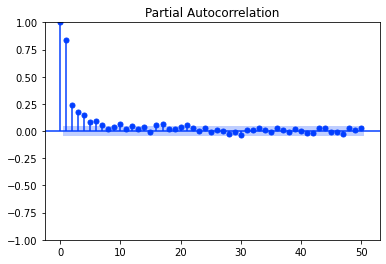

In [209]:
plot_pacf(extract_aq_df('so2','STA.IT1509A')['AQ_so2'],lags=50,method='ywm');

In [210]:
# adfuller for checking the trend of station's 1297 data
interpret_dftest(adfuller(extract_aq_df('so2','STA.IT1509A')['AQ_so2'].dropna()))
# No trend

Test Statistic   -2.962513
p-value           0.038547
dtype: float64

In [211]:
train, test = train_test_time_series('STA.IT1509A', 'so2',test_size=0.05)
train.shape, test.shape

((2017,), (107,))

In [212]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [213]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 8957.690156665445
MSE: 4.646300519305903


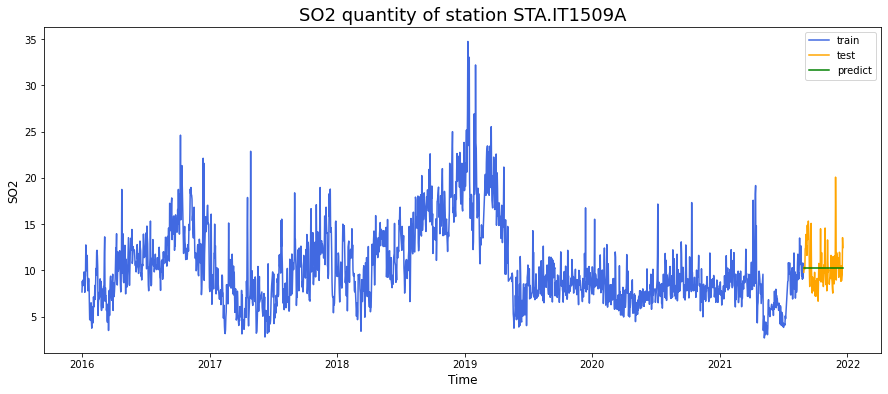

In [214]:
station_arima_graph(train, test, preds, 'SO2', 'STA.IT1509A')

In [215]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/so2_arima_gridsearch.csv',index=False)

In [216]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/so2_arima_gridsearch.csv')

In [217]:
manual_grid.sort_values('aic').head()

p    d    q          aic       mse
70   4.0  1.0  1.0  8666.651503  4.783025
13   1.0  1.0  4.0  8666.944011  4.885364
12   1.0  1.0  3.0  8667.487907  4.799338
112  6.0  1.0  3.0  8667.739036  4.857183
14   1.0  1.0  5.0  8667.797577  4.853499

In [218]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(4,1,1))
preds, aic, mse = fit_preds(ar1, test)

AIC: 8666.651502637309
MSE: 4.7830245846081425


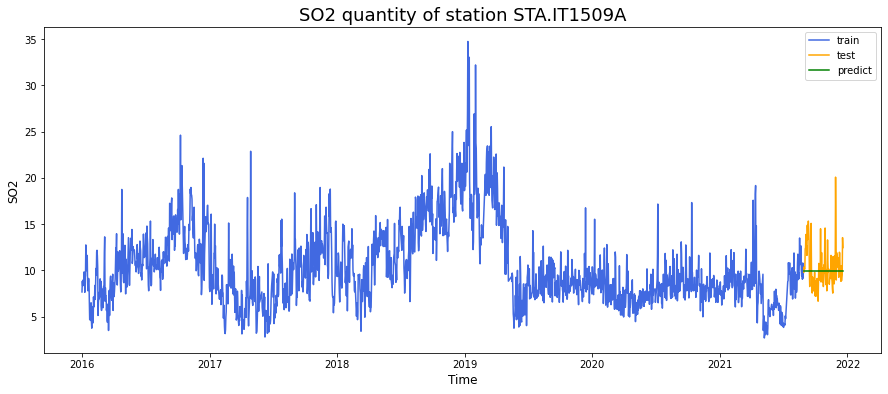

In [219]:
station_arima_graph(train, test, preds, 'SO2', 'STA.IT1509A')

### RNN Model

In [220]:
X_train, X_test, y_train, y_test = extract_split('so2', 'STA.IT1509A')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [221]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))


# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [222]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 11.92
Testing loss: 16.34
MAPE: 31.39
Baseline RMSE: 4.92
RMSE: 3.91


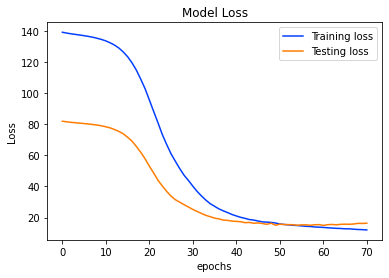

In [223]:
loss_graph()
model_error()

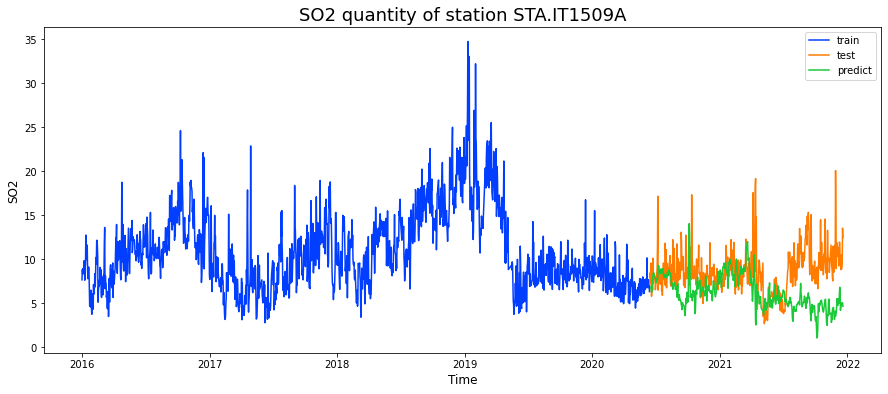

In [224]:
nn_result_graph('SO2', 'STA.IT1509A')

### LSTM model

In [225]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(16, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.1)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.1)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.1)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.00005, 
                             train_sequences, test_sequences,
                             150, es)

In [226]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mse
Training loss: 39.56
Testing loss: 18.46
MAPE: 37.73
Baseline RMSE: 3.45
RMSE: 3.49


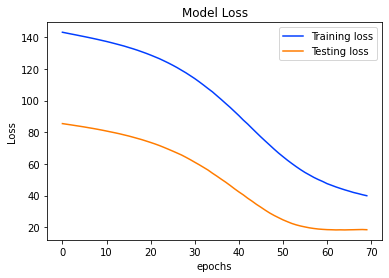

In [227]:
loss_graph()
model_error()

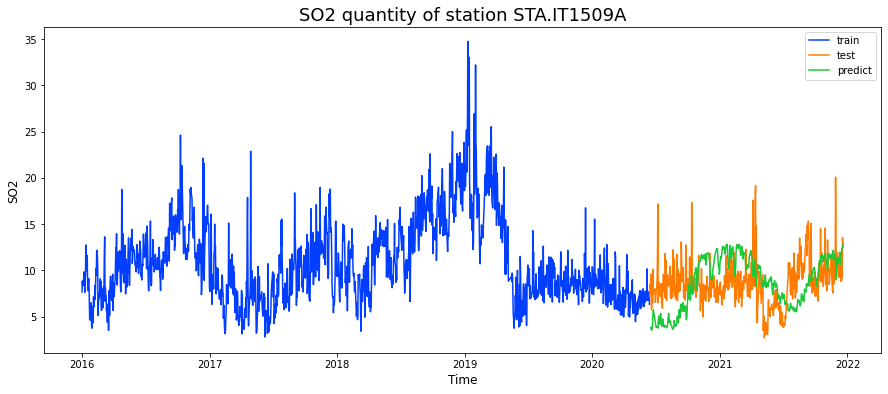

In [228]:
nn_result_graph('SO2', 'STA.IT1509A')

### LSTM model with feature engineering

In [229]:
data = extract_aq_df('so2','STA.IT1509A')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_so2'] = data['AQ_so2'].rolling(window=7).mean()
data['rolling15_so2'] = data['AQ_so2'].rolling(window=14).mean()
data['rolling30_so2'] = data['AQ_so2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_so2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [230]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [231]:
# Design LSTM
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.0001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es, loss='mean_absolute_error')

In [232]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Loss function: mean_absolute_error
Training loss: 1.84
Testing loss: 2.22
MAPE: 24.11
Baseline RMSE: 4.16
RMSE: 3.03


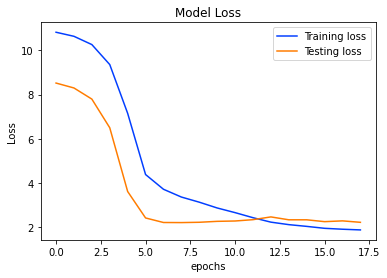

In [233]:
loss_graph()
model_error()

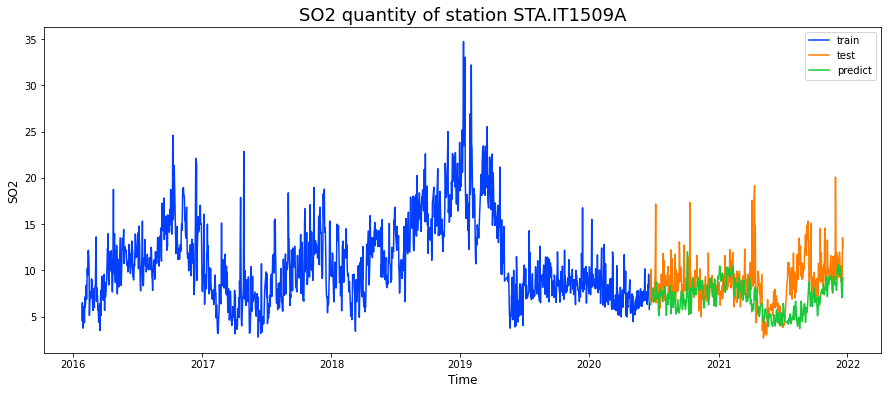

In [234]:
nn_result_graph('SO2', 'STA.IT1509A')

## Final model for predicting pollutants
Since, Neural networks model in Keras have a lot of randomness such as random initial weight in the layer, random initial point of gredient descent etc. The models that used in conclusion section are saved from modeling section. The following function is the functions using in the conclusion section.

In [564]:
# Creating dataframe for saving the result from final model
final_model_result = pd.DataFrame(columns=['pollutant','loss_func','train_loss', 'test_loss','mape','baseline_rmse','rmse'])

# Creating dataframe for saving the comparing aqi
exceed_result = pd.DataFrame(columns=['pollutant', 'aqi','Condition','Day_exceed_aqi','Preds_exceed_aqi', 'Accuracy'])

In [406]:
# Function for storing data for conclusion section
def store_conclusion(X_test, y_test, y_preds):
    return X_test.copy(), y_test.copy(), y_preds.copy()

In [501]:
def graph_test_preds(X_test,y_test, y_preds, quality_title, station,ax=None):
    sns.lineplot(x=X_test.index, y=y_test, label='test',color='darkorange', ax=ax)
    sns.lineplot(x=X_test.index[3:], y=y_preds[:,0], label='predict', color='limegreen', ax=ax)
    if ax == None:
        plt.title(f'{quality_title} quantity of station {station}')
        plt.ylabel(quality_title)
        plt.xlabel('Time')
        plt.xticks(rotation=45)
        plt.legend();
    else:
        ax.set_title(f'{quality_title} quantity of station {station}')
        ax.set_ylabel(quality_title)
        ax.set_xlabel('Time')
        ax.legend()

### Pollutant: NO$_{x}$ (station 652)
**Model**: LSTM model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [566]:
model = load_model('./model/nox_LSTM_feature_eng.h5')

In [567]:
data = extract_aq_df('nox','652')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling15_nox'] = data['AQ_nox'].rolling(window=15).mean()
data['rolling30_nox'] = data['AQ_nox'].rolling(window=30).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nox']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [568]:
# Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [569]:
result_nox = model_error();
final_model_result.loc[0] = ['NOx','mae'] + result_nox

Loss function: <function mean_absolute_error at 0x00000207D2643310>
Training loss: 35.58
Testing loss: 33.84
MAPE: 36.65
Baseline RMSE: 77.03
RMSE: 44.75


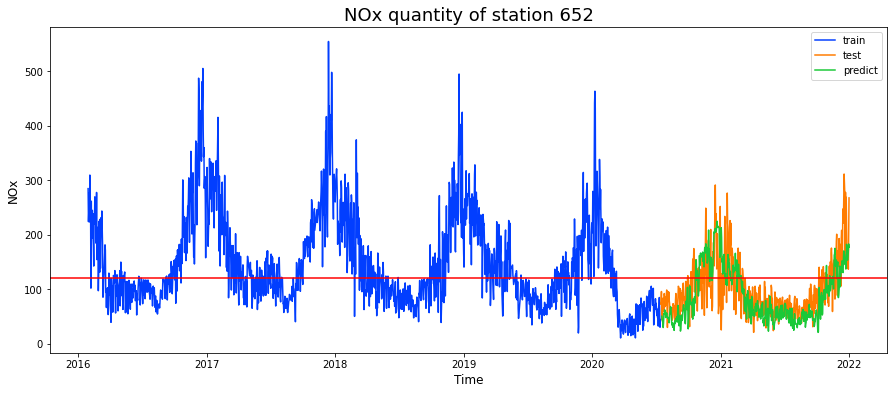

In [570]:
nn_result_graph('NOx', '652', aqi=120)

In [571]:
# storing the data for conclusion section
X_test_nox, y_test_nox, y_preds_nox = store_conclusion(X_test, y_test, y_preds)

In [572]:
# Check amount of days that have nox in air quality > 120 (index level: poor)
nox_exceed = air_exceed_threshold(y_test, y_preds, 'nox', 120)
exceed_result.loc[0] = ['NOx',120, 'poor'] + nox_exceed

Number of days having nox > 120: 153
Number of days predict nox > 120: 102
Predict nox > 120: 66.67%


### Pollutant: NO$_{2}$ (station 501)
**Model**: LSTM model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [573]:
model = load_model('./model/no2_LSTM_feature_eng.h5')

In [574]:
data = extract_aq_df('no2','501')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_no2'] = data['AQ_no2'].rolling(window=12).mean()
data['rolling14_no2'] = data['AQ_no2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_no2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [575]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [576]:
# Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


In [577]:
result_no2 = model_error();
final_model_result.loc[1] = ['NO2','mae'] + result_no2

Loss function: <function mean_squared_error at 0x00000207D2643040>
Training loss: 179.76
Testing loss: 228.24
MAPE: 34.21
Baseline RMSE: 19.3
RMSE: 15.07


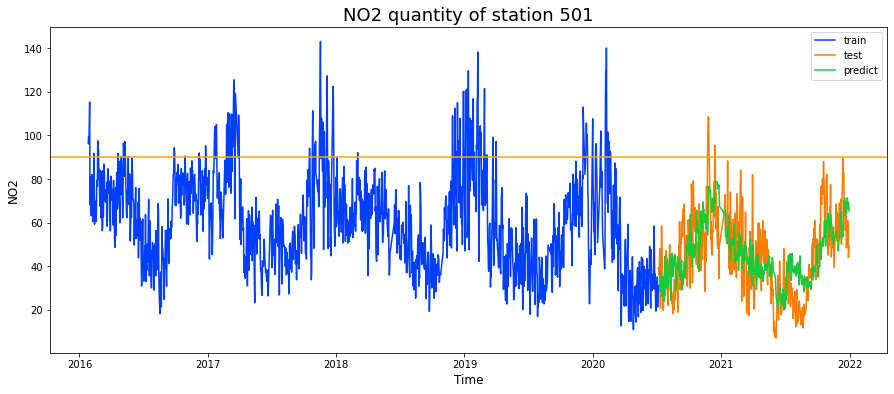

In [578]:
nn_result_graph('NO2', '501', aqi=90, color='orange')

In [579]:
# storing the data for conclusion section
X_test_no2, y_test_no2, y_preds_no2 = store_conclusion(X_test, y_test, y_preds)

In [580]:
# Check amount of days that have no2 in air quality > 90 (index level: medium)
no2_exceed = air_exceed_threshold(y_test, y_preds, 'no2', 90)
exceed_result.loc[1] = ['NO2',90, 'medium'] + no2_exceed

Number of days having no2 > 90: 6
Number of days predict no2 > 90: 0
Predict no2 > 90: 0.0%


### Pollutant: NH$_{3}$ (station 626)
**Model**: LSTM model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [581]:
model = load_model('./model/nh3_LSTM_feature_eng.h5')

In [582]:
data = extract_aq_df('nh3','626')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_nh3'] = data['AQ_nh3'].rolling(window=15).mean()
data['rolling26_nh3'] = data['AQ_nh3'].rolling(window=30).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nh3']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [583]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [584]:
# Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


In [585]:
result_nh3 = model_error();
final_model_result.loc[2] = ['NH3','mae'] + result_nh3

Loss function: <function mean_absolute_error at 0x00000207D2643310>
Training loss: 13.35
Testing loss: 20.46
MAPE: 76.68
Baseline RMSE: 22.68
RMSE: 26.55


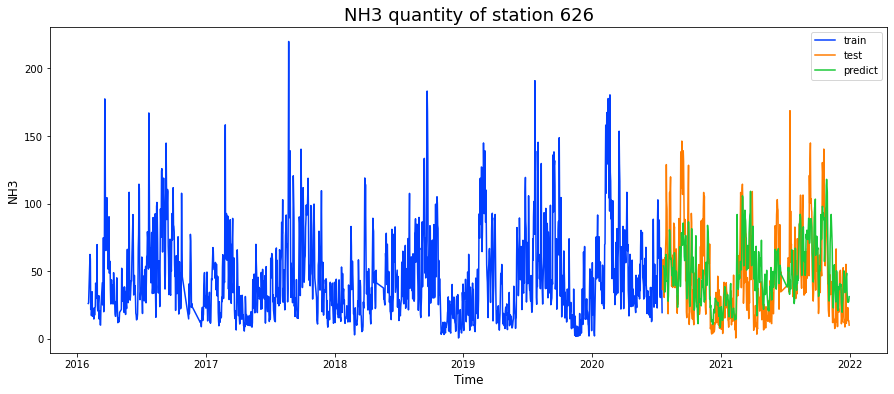

In [586]:
nn_result_graph('NH3', '626')

In [587]:
# storing the data for conclusion section
X_test_nh3, y_test_nh3, y_preds_nh3 = store_conclusion(X_test, y_test, y_preds)

### Pollutant: PM$_{10}$ (station 661)
**Model**: LSTM model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [588]:
model = load_model('./model/pm10_LSTM_feature_eng.h5')

In [589]:
data = extract_aq_df('pm10','661')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_pm10'] = data['AQ_pm10'].rolling(window=7).mean()
data['rolling15_pm10'] = data['AQ_pm10'].rolling(window=12).mean()
data['rolling30_pm10'] = data['AQ_pm10'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm10']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [590]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [591]:
# Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


In [592]:
result_pm10 = model_error();
final_model_result.loc[3] = ['PM10','mae'] + result_pm10

Loss function: <function mean_absolute_error at 0x00000207D2643310>
Training loss: 8.23
Testing loss: 13.87
MAPE: 57.9
Baseline RMSE: 18.28
RMSE: 18.46


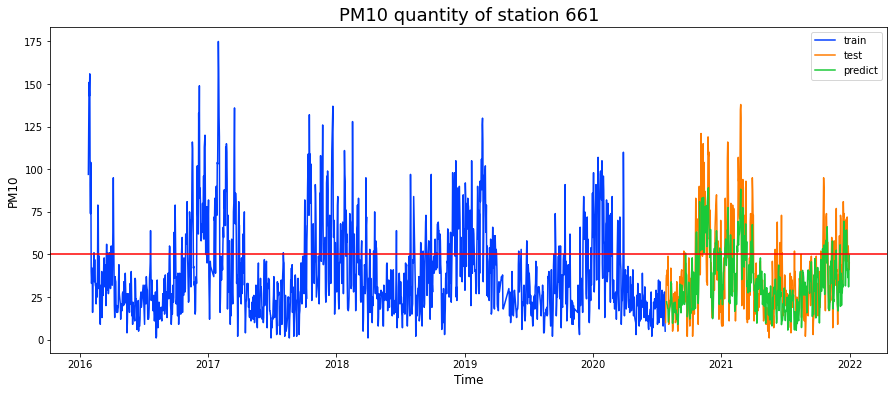

In [593]:
nn_result_graph('PM10', '661', aqi=50)

In [594]:
# storing the data for conclusion section
X_test_pm10, y_test_pm10, y_preds_pm10 = store_conclusion(X_test, y_test, y_preds)

In [595]:
# Check amount of days that have pm10 in air quality > 50 (index level: poor)
pm10_exceed = air_exceed_threshold(y_test, y_preds, 'pm10', 50)
exceed_result.loc[2] = ['PM10',50, 'poor'] + pm10_exceed

Number of days having pm10 > 50: 128
Number of days predict pm10 > 50: 78
Predict pm10 > 50: 60.94%


### Pollutant: PM$_{2.5}$ (station 1297)
**Model**: RNN model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [596]:
model = load_model('./model/pm25_RNN_feature_eng.h5')

In [597]:
data = extract_aq_df('pm25','1297')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_pm25'] = data['AQ_pm25'].rolling(window=12).mean()
data['rolling26_pm25'] = data['AQ_pm25'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm25']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [598]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [599]:
# Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [600]:
result_pm25 = model_error()
final_model_result.loc[4] = ['PM2.5','mae'] + result_pm25

Loss function: <function mean_absolute_error at 0x00000207D2643310>
Training loss: 6.55
Testing loss: 10.21
MAPE: 60.8
Baseline RMSE: 16.05
RMSE: 12.98


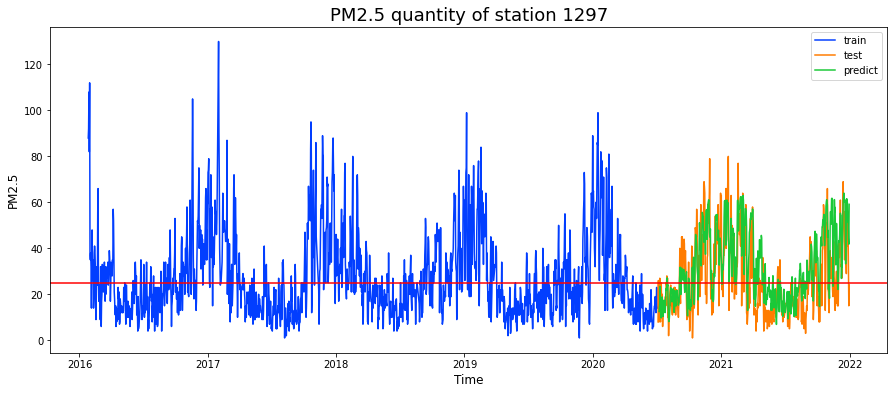

In [601]:
nn_result_graph('PM2.5', '1297', aqi=25)

In [602]:
# storing the data for conclusion section
X_test_pm25, y_test_pm25, y_preds_pm25 = store_conclusion(X_test, y_test, y_preds)

In [603]:
# Check amount of days that have pm2.5 in air quality > 50 (index level: poor)
pm25_exceed = air_exceed_threshold(y_test, y_preds, 'pm25', 50)
exceed_result.loc[3] = ['PM2.5', 50, 'poor'] + pm25_exceed

Number of days having pm25 > 50: 54
Number of days predict pm25 > 50: 36
Predict pm25 > 50: 66.67%


### Pollutant: SO$_{2}$ (station STA.IT509A)
**Model**: RNN model

**Feature engineering**: Dummy variable, Rolling average, Date time columns

In [604]:
model = load_model('./model/so2_LSTM_feature_eng.h5')

In [605]:
data = extract_aq_df('so2','STA.IT1509A')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_so2'] = data['AQ_so2'].rolling(window=7).mean()
data['rolling15_so2'] = data['AQ_so2'].rolling(window=14).mean()
data['rolling30_so2'] = data['AQ_so2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_so2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [606]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [607]:
# Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


In [608]:
result_so2 = model_error();
final_model_result.loc[5] = ['SO2','mae'] + result_so2

Loss function: <function mean_absolute_error at 0x00000207D2643310>
Training loss: 1.26
Testing loss: 1.75
MAPE: 22.22
Baseline RMSE: 2.51
RMSE: 2.37


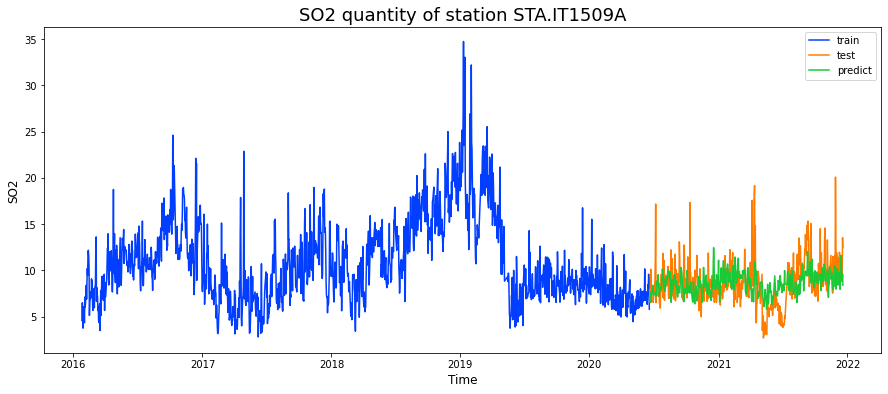

In [609]:
nn_result_graph('SO2', 'STA.IT1509A')

In [610]:
# storing the data for conclusion section
X_test_so2, y_test_so2, y_preds_so2 = store_conclusion(X_test, y_test, y_preds)

# Conclusion
---

### 1. Model for predicting amount of pollutants in the air. 
- The best model for almost all pollutant in this project is LSTM model. 
- The models tend to be better models with dummying the categorical variables, adding the date time part and moving average to the model. We have to tune the model separately for each pollutants.

In [404]:
final_model_result

pollutant loss_func  train_loss  test_loss   mape  baseline_rmse   rmse
0       nox       mae       35.58      33.84  36.65          77.03  44.75
1       no2       mae      179.76     228.24  34.21          19.30  15.07
2       nh3       mae       13.35      20.46  76.68          22.68  26.55
3      pm10       mae        8.23      13.87  57.90          18.28  18.46
4     pm2.5       mae        6.55      10.21  60.80          16.05  12.98
5       so2       mae        1.26       1.75  22.22           2.51   2.37

**Note** - mae: mean absolute error

From the final model result, we can conclude the result into **3 scenarios**.

**Scenario 1:** NOx, NO2, and PM2.5 model have similar/lower rmse to/than baseline rmse and the model could capture trend of the data. The following graphs show results from the models. Even though, The PM10 model rmse is higher than baseline rmse, the model could capture trend of the data.
- All 4 models have similar trend to some part in training set.

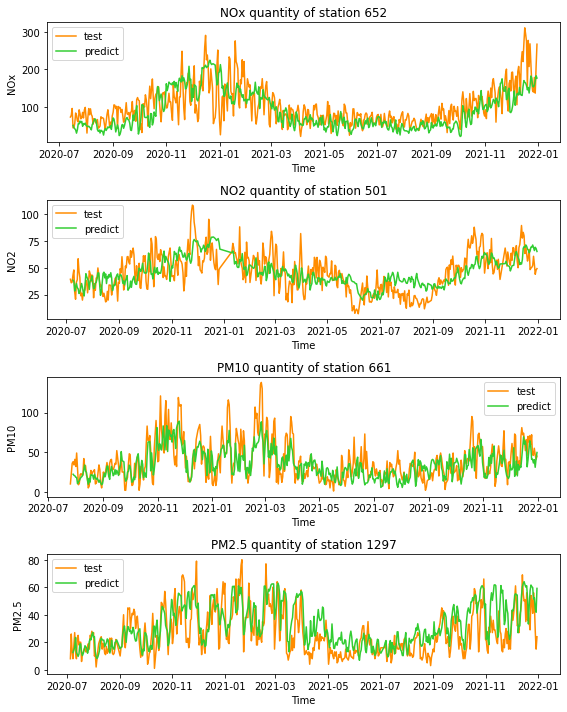

In [506]:
fig, ax = plt.subplots(nrows=4, figsize=(8,10))
graph_test_preds(X_test_nox, y_test_nox, y_preds_nox, 'NOx', '652', ax[0])
graph_test_preds(X_test_no2, y_test_no2, y_preds_no2, 'NO2', '501', ax[1])
graph_test_preds(X_test_pm10, y_test_pm10, y_preds_pm10, 'PM10', '661', ax[2])
graph_test_preds(X_test_pm25, y_test_pm25, y_preds_pm25, 'PM2.5', '1297', ax[3])
plt.tight_layout()

**Scenario 2:** NH3 model has higher rmse than baseline rmse and the model can capture some trend of the data. The following graph shows result from the model.
- NH3 data might have trend in the training data. This data have a lot of spike peak, so it may be hard for the model for capture all peaks. 

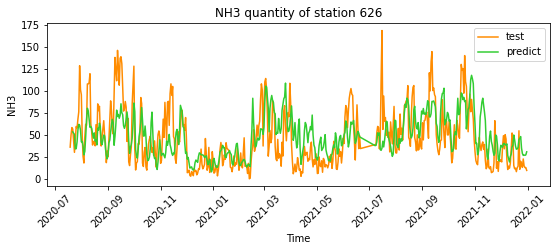

In [516]:
plt.figure(figsize=(9,3))
graph_test_preds(X_test_nh3, y_test_nh3, y_preds_nh3, 'NH3', '626')

**Scenario 3:** Even though, SO2 model has lower rmse than baseline rmse, the model quite can't capture the trend of the data.
- SO2 training data doesn't have obvious trend, it might be hard for the model to predict the SO2 quantity.

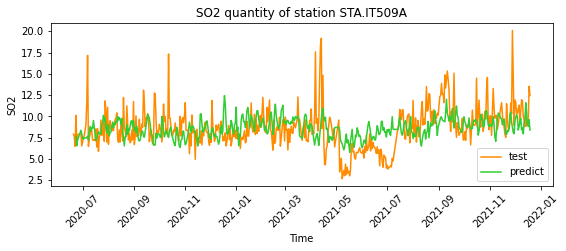

In [517]:
plt.figure(figsize=(9,3))
graph_test_preds(X_test_so2, y_test_so2, y_preds_so2, 'SO2', 'STA.IT509A')

Model in **Scenario 1** is good score and can capture the trend in the data, e.g. NOx, NO2, PM10 and PM2.5 model.

### 2. Identify the bad air quality days from the model and comparing to the actual value.
The data of bad air quality days is following the Day_exceed_aqi column in dataframe below. The predictions of bad air quality days are collect in pred_exceed_aqi column.

In [611]:
exceed_result

pollutant  aqi Condition  Day_exceed_aqi  Preds_exceed_aqi  Accuracy
0       NOx  120      poor             153               102     66.67
1       NO2   90    medium               6                 0      0.00
2      PM10   50      poor             128                78     60.94
3     PM2.5   50      poor              54                36     66.67

From the dataframe, we can conclude into 2 points.

**2.1.** There are 6 days of NO2 quantity above aqi threshold and all days are peak of the data as shown in graph below. So, It might be hard for the model to capture these days. 

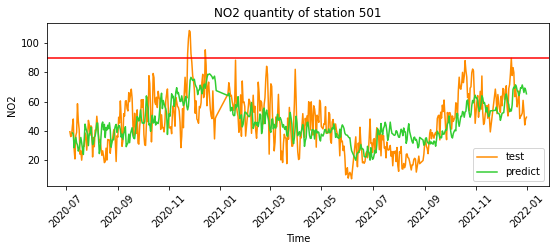

In [615]:
plt.figure(figsize=(9,3))
graph_test_preds(X_test_no2, y_test_no2, y_preds_no2, 'NO2', '501')
plt.axhline(90, color='red');

**Note** - Red line is threshold of medium air quality (NO2 > 90).

**2.2.** The best Models for predicting NOx, PM10 and PM2.5 can predict the bad air quality correctly about 60 - 67% as shown in above dataframe. The model can capture some peak of the data which is useful data for planning the new strategies. The example of model that can capture the peak of the data is displayed in the graph below.

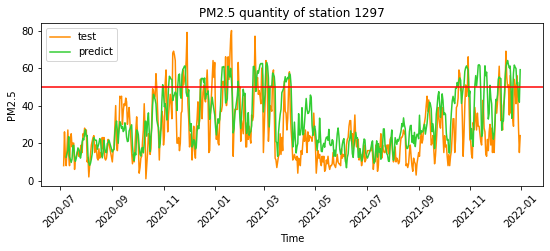

In [617]:
plt.figure(figsize=(9,3))
graph_test_preds(X_test_pm25, y_test_pm25, y_preds_pm25, 'PM2.5', '1297')
plt.axhline(50, color='red');

**Note** - Red line is threshold of poor air quality (PM2.5 > 50).

# Recommendation
---